### Dependencies
All required modules are listed in requirements.txt. Be sure to run the code cell below to ensure that you have everything needed properly installed.

In [110]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Imports
We're going to use a couple modules in this project, most notably:
- _matplotlib_ and _seaborn_, for plotting
- _sklearn_, for metrics, preprocessing and the MLP regressor
- _xgboost_, for the XGB regressor
- _optuna_, for fine-tuning hyperparameters

In [111]:
import os
from time import time
import tracemalloc

import ipywidgets as widgets
from IPython.display import display

import numpy as np
from scipy.special import softmax, kl_div, rel_entr
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

import optuna

### Experiments
The city viewer is capable of computing metrics regarding the quality of building views and generating datasets containing this information, as well as data on how efficient this computation was. These datasets are called 'Experiments' and are divided into two subsets: 'Data' and 'Performance'.

In [112]:
experiment_name = None
parent_dir_path = "experiments"

# Get the list of subdirectories
subdir_paths = [d for d in os.listdir(parent_dir_path) if os.path.isdir(os.path.join(parent_dir_path, d))]

# Create a dropdown widget
subdir_dropdown = widgets.Dropdown(
    options=subdir_paths,
    description="Experiment:",
    disabled=False,
)

# Display the selected subdirectory
def on_subdir_change(change):
    global experiment_name
    if change["type"] == "change" and change["name"] == "value":
        experiment_name = change['new']
        print(f"Selected Experiment: {change['new']}")

subdir_dropdown.observe(on_subdir_change)

# Display the dropdown widget
display(subdir_dropdown)

Dropdown(description='Experiment:', options=('edge', 'standard', 'tall', 'test'), value='edge')

Selected Experiment: tall


##### Performance DataFrame

In [114]:
performance_df = pd.read_csv(f"experiments/{experiment_name}/{experiment_name}_performance.csv")
performance_df

,building_id,num_camera_setups,execution_time,memory_usage
0,265,96,92.351186,1144
1,265,432,458.716905,8800
2,265,384,415.710988,3168


##### Data DataFrame

In [115]:
data_df = pd.read_csv(f"experiments/{experiment_name}/{experiment_name}_data.csv")
data_df

,building_id,origin_x,origin_y,origin_z,x,y,z,yaw,building_rate,landmark_rate,amenity_rate,tree_rate,water_rate,sky_rate,min_depth,max_depth,avg_depth
0,265,351.143188,14.77094,-280.873108,3.622369e+01,0.000000e+00,0.000000e+00,-180.0,0.107844,0.179970,0.000000,0.007606,0.000000,0.704580,1.000000,1000.0,8.046492
1,265,351.143188,14.77094,-280.873108,3.622369e+01,0.000000e+00,0.000000e+00,-90.0,0.057166,0.173997,0.044868,0.004993,0.000000,0.718976,1.676198,1000.0,33.757915
2,265,351.143188,14.77094,-280.873108,-1.073745e+08,-1.073742e+08,-1.073739e+08,-180.0,0.000000,0.000000,0.000000,0.000000,0.000000,72.000000,1000.000000,1000.0,1000.000000
3,265,351.143188,14.77094,-280.873108,-1.073745e+08,-1.073742e+08,-1.073739e+08,-90.0,0.000000,0.000000,0.000000,0.000000,0.000000,80.000000,1000.000000,1000.0,1000.000000
4,265,351.143188,14.77094,-280.873108,0.000000e+00,0.000000e+00,0.000000e+00,-180.0,0.405833,0.012604,0.000000,0.000000,0.000000,0.581563,1.011650,1000.0,7.561088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,265,351.143188,14.77094,-280.873108,0.000000e+00,1.725000e+02,1.727499e+01,150.0,0.453933,0.094302,0.012342,0.077055,0.000443,1.361925,58.283855,1000.0,616.565674
672,265,351.143188,14.77094,-280.873108,0.000000e+00,1.725000e+02,1.727499e+01,210.0,0.380611,0.314540,0.023498,0.075128,0.000000,1.206223,57.535160,1000.0,535.354858
673,265,351.143188,14.77094,-280.873108,-1.073745e+08,-1.073742e+08,-1.073739e+08,90.0,0.000000,0.000000,0.000000,0.000000,0.000000,108.000000,1000.000000,1000.0,1000.000000
674,265,351.143188,14.77094,-280.873108,-1.073745e+08,-1.073742e+08,-1.073739e+08,150.0,0.000000,0.000000,0.000000,0.000000,0.000000,39.000000,1000.000000,1000.0,1000.000000


##### Helper Function to Plot The Execution Time and Memory Usage per Building

In [116]:
def plot_series(ax, df, y_col, series_index=0):
    palette = list(sns.palettes.mpl_palette("Dark2"))
    xs = df["num_camera_setups"]
    ys = df[y_col]
    building_id = df["building_id"].iloc[0]

    color = palette[series_index % len(palette)]
    
    ax.plot(xs, ys, label=f"Building {building_id}", color=color)

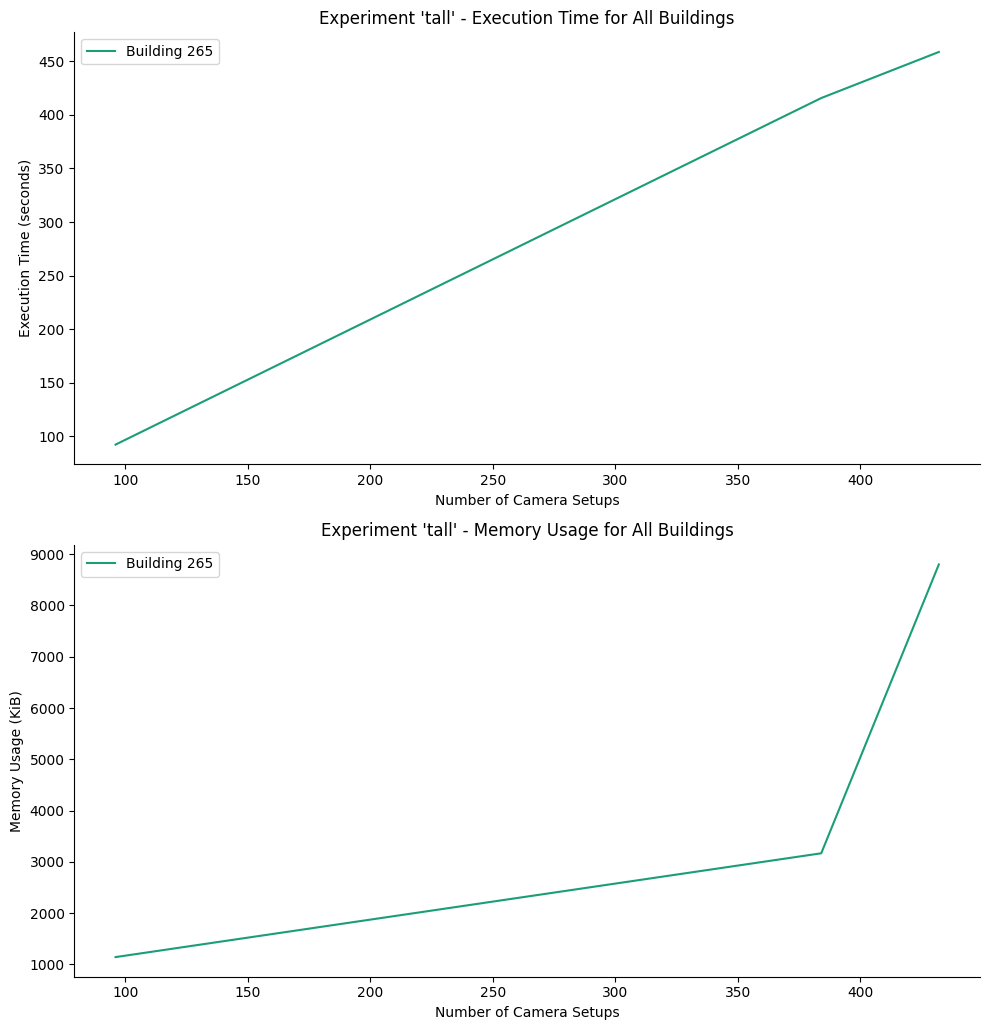

In [117]:
# Get unique building IDs
building_ids = performance_df["building_id"].unique()

# Create subplots for execution time and memory usage
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10.4))

for idx, building_id in enumerate(building_ids):
    df_filtered = performance_df[performance_df["building_id"] == building_id]
    df_sorted = df_filtered.sort_values("execution_time", ascending=True)
    
    plot_series(ax1, df_sorted, "execution_time", series_index=idx)
    plot_series(ax2, df_sorted, "memory_usage", series_index=idx)

ax1.set_xlabel("Number of Camera Setups")
ax1.set_ylabel("Execution Time (seconds)")
ax1.set_title(f"Experiment '{experiment_name}' - Execution Time for All Buildings")
ax1.legend(loc="upper left")
sns.despine(fig=fig, ax=ax1)

ax2.set_xlabel("Number of Camera Setups")
ax2.set_ylabel("Memory Usage (KiB)")
ax2.set_title(f"Experiment '{experiment_name}' - Memory Usage for All Buildings")
ax2.legend(loc="upper left")
sns.despine(fig=fig, ax=ax2)

plt.tight_layout()
plt.show()

### View Index

In [118]:
def calculate_index(building_rate, landmark_rate, amenity_rate, tree_rate, water_rate, sky_rate, avg_depth):
    building_weight = -1.0  # Negative because greater building rate should decrease the index
    landmark_weight =  1.0
    amenity_weight  =  1.0
    tree_weight     =  1.0
    water_weight    =  1.0
    sky_weight      =  1.0
    depth_weight    =  1.0

    raw_index = (building_rate * building_weight +
                 landmark_rate * landmark_weight +
                 amenity_rate * amenity_weight +
                 tree_rate * tree_weight +
                 water_rate * water_weight +
                 sky_rate * sky_weight +
                 avg_depth * depth_weight)

    # Define the minimum and maximum possible values for normalization
    min_index = building_weight * 1 + 0                                     # Worst case: all pixels are buildings
    max_index = (landmark_weight + amenity_weight + tree_weight +
                 water_weight + sky_weight) * 1 + depth_weight * avg_depth  # Best case: all pixels are non-building + maximum depth

    # Normalize the raw index to be between 0 and 1
    normalized_index = (raw_index - min_index) / (max_index - min_index)

    # Constrain the index within the range [0, 1]
    normalized_index = max(0, min(1, normalized_index))

    return normalized_index

In [119]:
data_df["view_index"] = data_df.apply(
    lambda row: calculate_index(
        row["building_rate"], row["landmark_rate"], row["amenity_rate"],
        row["tree_rate"], row["water_rate"], row["sky_rate"], row["avg_depth"]
    ), axis=1
)

In [120]:
data_df

,building_id,origin_x,origin_y,origin_z,x,y,z,yaw,building_rate,landmark_rate,amenity_rate,tree_rate,water_rate,sky_rate,min_depth,max_depth,avg_depth,view_index
0,265,351.143188,14.77094,-280.873108,3.622369e+01,0.000000e+00,0.000000e+00,-180.0,0.107844,0.179970,0.000000,0.007606,0.000000,0.704580,1.000000,1000.0,8.046492,0.699876
1,265,351.143188,14.77094,-280.873108,3.622369e+01,0.000000e+00,0.000000e+00,-90.0,0.057166,0.173997,0.044868,0.004993,0.000000,0.718976,1.676198,1000.0,33.757915,0.896515
2,265,351.143188,14.77094,-280.873108,-1.073745e+08,-1.073742e+08,-1.073739e+08,-180.0,0.000000,0.000000,0.000000,0.000000,0.000000,72.000000,1000.000000,1000.0,1000.000000,1.000000
3,265,351.143188,14.77094,-280.873108,-1.073745e+08,-1.073742e+08,-1.073739e+08,-90.0,0.000000,0.000000,0.000000,0.000000,0.000000,80.000000,1000.000000,1000.0,1000.000000,1.000000
4,265,351.143188,14.77094,-280.873108,0.000000e+00,0.000000e+00,0.000000e+00,-180.0,0.405833,0.012604,0.000000,0.000000,0.000000,0.581563,1.011650,1000.0,7.561088,0.645186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,265,351.143188,14.77094,-280.873108,0.000000e+00,1.725000e+02,1.727499e+01,150.0,0.453933,0.094302,0.012342,0.077055,0.000443,1.361925,58.283855,1000.0,616.565674,0.993723
672,265,351.143188,14.77094,-280.873108,0.000000e+00,1.725000e+02,1.727499e+01,210.0,0.380611,0.314540,0.023498,0.075128,0.000000,1.206223,57.535160,1000.0,535.354858,0.993052
673,265,351.143188,14.77094,-280.873108,-1.073745e+08,-1.073742e+08,-1.073739e+08,90.0,0.000000,0.000000,0.000000,0.000000,0.000000,108.000000,1000.000000,1000.0,1000.000000,1.000000
674,265,351.143188,14.77094,-280.873108,-1.073745e+08,-1.073742e+08,-1.073739e+08,150.0,0.000000,0.000000,0.000000,0.000000,0.000000,39.000000,1000.000000,1000.0,1000.000000,1.000000


In [121]:
X = data_df[["x", "y", "z", "yaw"]]
Y = data_df["view_index"]
Y_multiout = data_df[["building_rate", "landmark_rate", "amenity_rate",
                       "tree_rate", "water_rate", "sky_rate",
                       "avg_depth"]]

In [122]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.7)
X_train, X_val, Y_multiout_train, Y_multiout_val = train_test_split(X, Y_multiout, test_size=0.7)

In [123]:
X_train

,x,y,z,yaw
364,-5.368726e+07,-5.368701e+07,-5.368695e+07,90.0
665,0.000000e+00,1.725000e+02,8.637512e+00,150.0
161,-1.073745e+08,-1.073742e+08,-1.073739e+08,150.0
601,-1.073745e+08,-1.073742e+08,-1.073739e+08,90.0
414,3.622369e+01,0.000000e+00,8.637512e+00,30.0
...,...,...,...,...
298,0.000000e+00,1.725000e+02,0.000000e+00,-180.0
170,-1.073745e+08,-1.073742e+08,-1.073739e+08,150.0
455,0.000000e+00,0.000000e+00,1.727499e+01,150.0
643,-1.073745e+08,-1.073742e+08,-1.073739e+08,0.0


In [124]:
X_val

,x,y,z,yaw
155,0.000000e+00,0.000000e+00,8.637512e+00,150.0
85,-5.368726e+07,-5.368710e+07,-5.368695e+07,-180.0
518,-1.073745e+08,-1.073742e+08,-1.073739e+08,150.0
386,-1.073745e+08,-1.073742e+08,-1.073739e+08,150.0
582,3.622369e+01,1.150000e+02,1.727499e+01,120.0
...,...,...,...,...
77,-5.368726e+07,-5.368710e+07,-5.368695e+07,-120.0
515,0.000000e+00,5.749999e+01,0.000000e+00,150.0
671,0.000000e+00,1.725000e+02,1.727499e+01,150.0
197,-1.073745e+08,-1.073742e+08,-1.073739e+08,-120.0


In [125]:
Y_train

498    0.963734
505    1.000000
421    1.000000
495    1.000000
175    0.996024
         ...   
29     0.772616
331    1.000000
235    0.730075
539    0.979115
41     0.976717
Name: view_index, Length: 202, dtype: float64

In [126]:
Y_val

394    0.834359
474    0.904828
230    0.996024
212    0.996024
468    0.755373
         ...   
553    1.000000
367    1.000000
630    0.993854
436    0.984803
188    1.000000
Name: view_index, Length: 474, dtype: float64

In [127]:
Y_multiout_train

,building_rate,landmark_rate,amenity_rate,tree_rate,water_rate,sky_rate,avg_depth
364,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1000.000000
665,0.454007,0.113282,0.013371,0.073438,0.000416,1.345485,592.249878
161,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,1000.000000
601,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,1000.000000
414,0.278121,0.144979,0.030124,0.064122,0.000000,1.482654,20.546055
...,...,...,...,...,...,...,...
298,0.457474,0.159967,0.016670,0.059150,0.000000,1.306740,585.351929
170,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,1000.000000
455,0.686117,0.001005,0.000000,0.003719,0.000000,1.309160,14.829914
643,0.000000,0.000000,0.000000,0.000000,0.000000,106.000000,1000.000000


In [128]:
Y_train_color = Y_multiout_train.values[:, :-1]
Y_train_color

array([[0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00],
       [4.540070e-01, 1.132820e-01, 1.337100e-02, 7.343800e-02,
        4.160000e-04, 1.345485e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 2.000000e+01],
       ...,
       [6.861170e-01, 1.005000e-03, 0.000000e+00, 3.719000e-03,
        0.000000e+00, 1.309160e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.060000e+02],
       [7.965600e-02, 6.612870e-01, 2.785400e-02, 6.758000e-03,
        0.000000e+00, 2.244450e-01]])

In [129]:
Y_train_depth = Y_multiout_train.values[:, -1]
Y_train_depth

array([1000.      ,  592.249878, 1000.      , 1000.      ,   20.546055,
       1000.      , 1000.      ,  429.440125, 1000.      ,   12.957269,
       1000.      ,  487.502991,   17.35424 ,   53.254112, 1000.      ,
       1000.      ,   39.156174, 1000.      , 1000.      ,   12.957269,
        222.711578, 1000.      ,  577.918884, 1000.      ,  507.181763,
        429.440125, 1000.      , 1000.      , 1000.      ,  149.252106,
       1000.      , 1000.      , 1000.      , 1000.      , 1000.      ,
       1000.      , 1000.      , 1000.      ,  167.0439  , 1000.      ,
       1000.      , 1000.      , 1000.      , 1000.      , 1000.      ,
        252.683533, 1000.      ,   17.412968, 1000.      ,  548.32666 ,
         78.079651, 1000.      ,  589.267761, 1000.      , 1000.      ,
       1000.      ,  281.555573, 1000.      , 1000.      , 1000.      ,
       1000.      , 1000.      , 1000.      ,  426.433472, 1000.      ,
       1000.      ,   60.937191, 1000.      ,  273.030273, 1000.

In [130]:
Y_multiout_val

,building_rate,landmark_rate,amenity_rate,tree_rate,water_rate,sky_rate,avg_depth
155,0.310465,0.011069,0.000000,0.000000,0.000000,0.678466,20.250586
85,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1000.000000
518,0.000000,0.000000,0.000000,0.000000,0.000000,31.000000,1000.000000
386,0.000000,0.000000,0.000000,0.000000,0.000000,27.000000,1000.000000
582,0.132515,0.485342,0.000636,0.020759,0.000070,0.360679,39.175461
...,...,...,...,...,...,...,...
77,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1000.000000
515,0.428222,0.170423,0.003885,0.072369,0.000000,0.325100,116.406624
671,0.453933,0.094302,0.012342,0.077055,0.000443,1.361925,616.565674
197,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,1000.000000


In [131]:
Y_val_color = Y_multiout_val.values[:, :-1]
Y_val_color

array([[3.104650e-01, 1.106900e-02, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 6.784660e-01],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 3.100000e+01],
       ...,
       [4.539330e-01, 9.430200e-02, 1.234200e-02, 7.705500e-02,
        4.430000e-04, 1.361925e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 2.400000e+01],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]])

In [132]:
Y_val_depth = Y_multiout_val.values[:, -1]
Y_val_depth

array([  20.250586, 1000.      , 1000.      , 1000.      ,   39.175461,
       1000.      ,  409.559052, 1000.      , 1000.      , 1000.      ,
       1000.      , 1000.      ,  100.378624, 1000.      ,  452.721741,
       1000.      ,   29.375694, 1000.      , 1000.      , 1000.      ,
       1000.      ,  255.417328,   16.410471, 1000.      ,   19.633642,
        320.413025,  188.686203, 1000.      ,    7.561088, 1000.      ,
        255.417328, 1000.      ,   19.814888, 1000.      ,   26.07439 ,
         13.860689,  331.962311,    7.561088,   70.727394, 1000.      ,
         11.729743,   33.757915, 1000.      ,  566.998901,   14.903487,
       1000.      ,   29.375694, 1000.      , 1000.      ,  156.729202,
        548.32666 , 1000.      , 1000.      , 1000.      , 1000.      ,
       1000.      , 1000.      , 1000.      , 1000.      , 1000.      ,
        434.531219,  280.754669,   15.692915,   15.253203,  535.354858,
       1000.      ,  566.01947 ,  337.390076, 1000.      , 1000.

In [133]:
column_names = Y_multiout.columns.tolist()

### Utilities

In [134]:
def kl_divergence(p, q):
    return np.sum(rel_entr(p, q))

def symmetrized_kl_divergence(p, q):
    return kl_divergence(p, q) + kl_divergence(q, p)

In [135]:
def plot_predicted_vs_actual(Y_val_color, Y_val_color_pred,
                             Y_val_depth, Y_val_depth_pred,
                             column_names):
    plt.figure(figsize=(15, 10))

    for i, column_name in enumerate(column_names[:-1]):
        plt.subplot(3, 3, i + 1)
        plt.scatter(Y_val_color_pred[:, i], Y_val_color[:, i], alpha=0.5)
        plt.plot([Y_val_color_pred[:, i].min(), Y_val_color_pred[:, i].max()],
                 [Y_val_color_pred[:, i].min(), Y_val_color_pred[:, i].max()], "r--")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Predicted vs Actual '{column_name}'")

    plt.subplot(3, 3, len(column_names))
    plt.scatter(Y_val_depth_pred, Y_val_depth, alpha=0.5)
    plt.plot([Y_val_depth_pred.min(), Y_val_depth_pred.max()],
             [Y_val_depth_pred.min(), Y_val_depth_pred.max()], "r--")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Predicted vs Actual '{column_names[-1]}'")

    plt.tight_layout()
    plt.show()

In [136]:
def compute_relative_errors(Y_val, Y_val_pred):
    with np.errstate(divide="ignore", invalid="ignore"):
        relative_errors = np.abs((Y_val - Y_val_pred) / Y_val)
        relative_errors[Y_val == 0] = np.nan
    return relative_errors

In [137]:
def plot_relative_errors(Y_val_color, Y_val_color_pred,
                         Y_val_depth, Y_val_depth_pred,
                         column_names):
    relative_errors_color = compute_relative_errors(Y_val_color, Y_val_color_pred)
    relative_errors_depth = compute_relative_errors(Y_val_depth, Y_val_depth_pred)

    plt.figure(figsize=(15, 10))

    for i, column_name in enumerate(column_names[:-1]):
        plt.subplot(3, 3, i + 1)
        sns.histplot(relative_errors_color[:, i], bins=30, kde=True)
        plt.xlabel("Relative Error")
        plt.ylabel("Frequency")
        plt.title(f"Relative Errors for '{column_name}'")

    plt.subplot(3, 3, len(column_names))
    sns.histplot(relative_errors_depth, bins=30, kde=True)
    plt.xlabel("Relative Error")
    plt.ylabel("Frequency")
    plt.title(f"Relative Errors for '{column_names[-1]}'")
    
    plt.tight_layout()
    plt.show()

In [138]:
def plot_cumulative_error_distribution(Y_val_color, Y_val_color_pred, 
                                       Y_val_depth, Y_val_depth_pred, 
                                       column_names):
    plt.figure(figsize=(15, 10))

    # Plot cumulative error distribution for color
    for i, column_name in enumerate(column_names[:-1]):
        plt.subplot(3, 3, i + 1)
        
        # Compute relative errors for color predictions
        errors = compute_relative_errors(Y_val_color[:, i], Y_val_color_pred[:, i])
        errors_sorted = np.sort(errors[~np.isnan(errors)])  # Remove NaNs and sort
        cumulative_percent = np.arange(1, len(errors_sorted) + 1) / len(errors_sorted) * 100
        
        plt.plot(errors_sorted, cumulative_percent, color='crimson')
        plt.xlabel("Relative Error")
        plt.ylabel("Cumulative Percentage")
        plt.title(f"Cumulative Error Distribution for '{column_name}'")
        plt.grid(True)
    
    # Plot cumulative error distribution for depth
    plt.subplot(3, 3, len(column_names))
    
    # Compute relative errors for depth predictions
    errors = compute_relative_errors(Y_val_depth, Y_val_depth_pred)
    errors_sorted = np.sort(errors[~np.isnan(errors)])  # Remove NaNs and sort
    cumulative_percent = np.arange(1, len(errors_sorted) + 1) / len(errors_sorted) * 100
    
    plt.plot(errors_sorted, cumulative_percent, color='crimson')
    plt.xlabel("Relative Error")
    plt.ylabel("Cumulative Percentage")
    plt.title(f"Cumulative Error Distribution for '{column_names[-1]}'")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

### Basic MLP Regressor

In [139]:
tracemalloc.start()
snapshot1 = tracemalloc.take_snapshot()

time1 = time()

mlp = MLPRegressor(hidden_layer_sizes=(10,10), max_iter=1000)
mlp.fit(X_train, Y_multiout_train)

time2 = time()

snapshot2 = tracemalloc.take_snapshot()
tracemalloc.stop()

training_time = time2 - time1

stats = snapshot2.compare_to(snapshot1, "lineno")
mem_usage = sum(stat.size_diff for stat in stats) / 1024

print(f"Time to train the mlp:        {training_time:.2f} seconds")
print(f"Total memory used by the mlp: {mem_usage:.2f} KiB")

Time to train the mlp:        2.31 seconds
Total memory used by the mlp: 34.82 KiB


In [140]:
Y_train_pred = mlp.predict(X_train)
Y_val_pred = mlp.predict(X_val)

Y_train_color_pred = Y_train_pred[:, :-1]
Y_train_depth_pred = Y_train_pred[:, -1]

Y_val_color_pred = Y_val_pred[:, :-1]
Y_val_depth_pred = Y_val_pred[:, -1]

# Calculate Euclidean distances
#train_dists = np.linalg.norm(Y_train - Y_train_pred, axis=1)
#val_dists = np.linalg.norm(Y_val - Y_val_pred, axis=1)

#train_loss = np.mean(train_dists**2)
#val_loss = np.mean(val_dists**2)

Y_train_color_pred = np.apply_along_axis(softmax, 1, Y_train_color_pred)
Y_val_color_pred = np.apply_along_axis(softmax, 1, Y_val_color_pred)

train_color_loss = symmetrized_kl_divergence(Y_train_color, Y_train_color_pred)
val_color_loss = symmetrized_kl_divergence(Y_val_color, Y_val_color_pred)

print(f"Training Loss - Color:   {train_color_loss}")
print(f"Validation Loss - Color: {val_color_loss}")

train_depth_loss = mean_squared_error(Y_train_depth, Y_train_depth_pred)
val_depth_loss = mean_squared_error(Y_val_depth, Y_val_depth_pred)

print(f"\nTraining Loss - Depth:   {train_depth_loss}")
print(f"Validation Loss - Depth: {val_depth_loss}")

Training Loss - Color:   inf
Validation Loss - Color: inf

Training Loss - Depth:   528152.6540202248
Validation Loss - Depth: 472532.1210206781


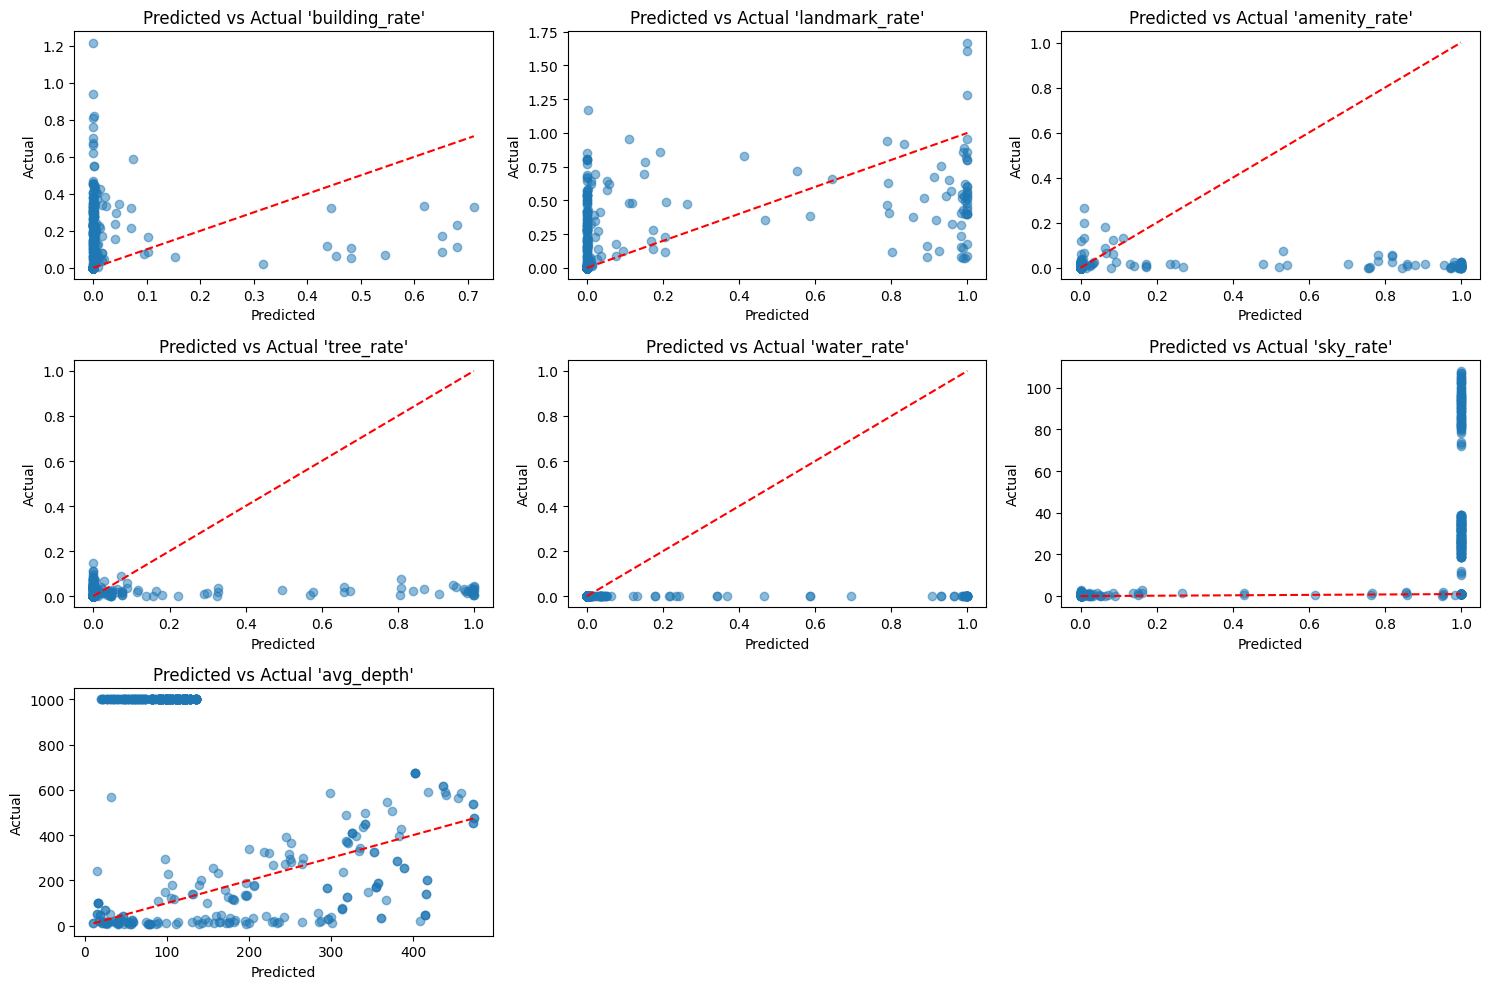

In [141]:
plot_predicted_vs_actual(Y_val_color, Y_val_color_pred,
                         Y_val_depth, Y_val_depth_pred,
                         column_names)

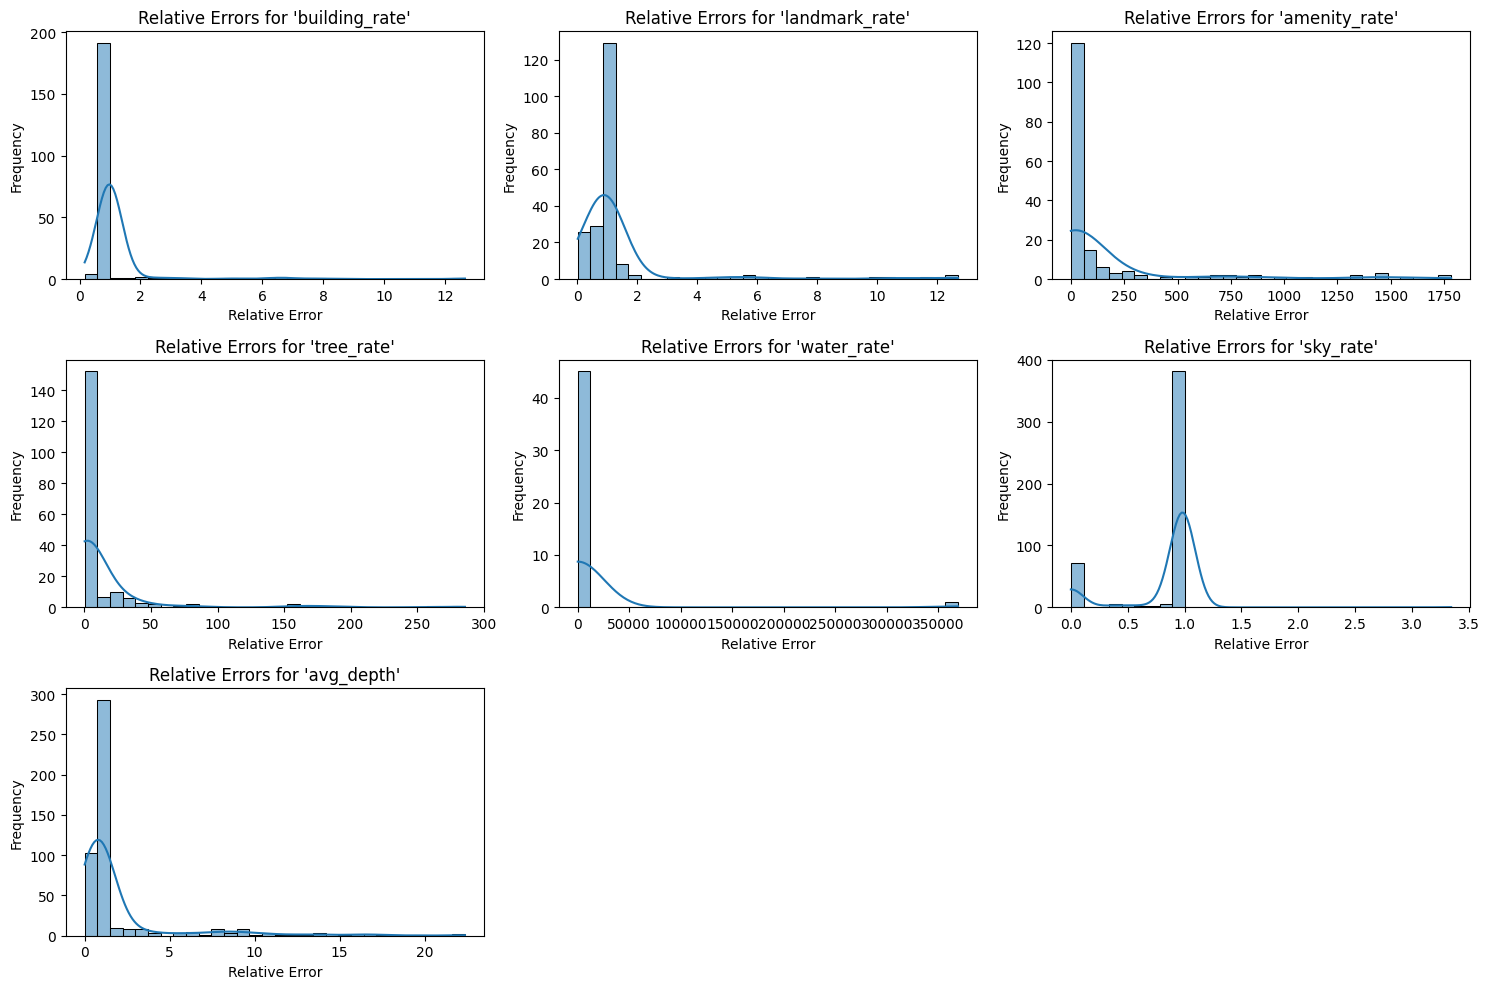

In [142]:
plot_relative_errors(Y_val_color, Y_val_color_pred,
                     Y_val_depth, Y_val_depth_pred,
                     column_names)

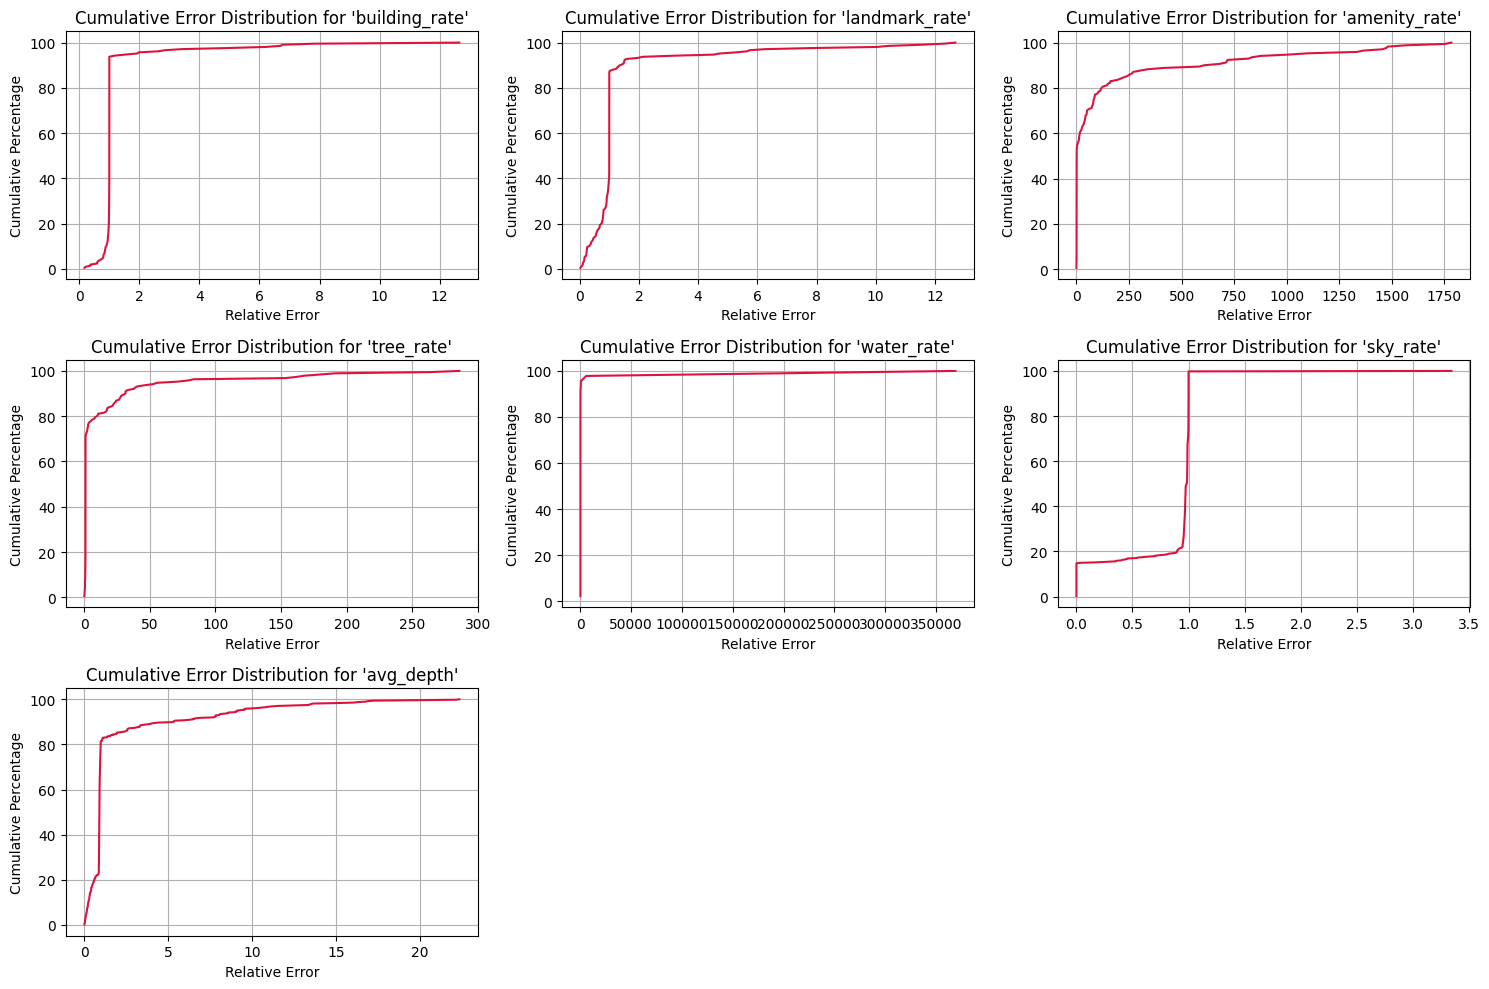

In [143]:
plot_cumulative_error_distribution(Y_val_color, Y_val_color_pred,
                                   Y_val_depth, Y_val_depth_pred,
                                   column_names)

### Hyperparameter Fine-Tuning
We will perform a hyperparameter fine-tuning for our regressor using Optuna. Here's an overview of what is being done:

1. Objective Function:
    - The objective function defines the optimization objective.
    - Within this function:
        - Hyperparameters are sampled for each trial using trial.suggest_* methods from Optuna.
        - A MLPRegressor model is instantiated with the sampled hyperparameters.
        - The model is trained for the specified number of epochs using the `fit` method, and its performance is evaluated using the `predict` method.
        - The trial's intermediate result (validation loss) is reported to Optuna for pruning.
        - If the trial is deemed unpromising and should be pruned, it is terminated early.

2. Optimization Process:
    - An Optuna study is created to conduct the hyperparameter optimization.
    - The objective function is optimized using the `study.optimize` method with a specified number of trials (num_trials).
    - Pruned trials (those terminated early due to being unpromising) are identified using `study.get_trials`.

3. Results Logging:
    - Various trial attributes such as total number of neurons, training time, memory usage and validation loss are stored using `trial.set_user_attr`.
    - The trained model's state dictionary is saved to a file with a timestamped filename in the models directory.

This process iteratively explores the hyperparameter space to find the set of hyperparameters that maximize the accuracy of the CNN model on the validation dataset.

In [144]:
def objective_mlp(trial):
    # Define the hyperparameter space
    hidden_layer_sizes = tuple([trial.suggest_int(f"n_units_l{i}", 10, 200, step=10) for i in range(1, trial.suggest_int("n_layers", 1, 2) + 1)])
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "logistic"])
    solver = "adam"#trial.suggest_categorical("solver", ["adam", "sgd", "lbfgs"])
    alpha = trial.suggest_float("alpha", 1e-5, 1e-1, log=True)
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-4, 1e-1, log=True)

    total_neurons = sum(hidden_layer_sizes)
    trial.set_user_attr("total_neurons", total_neurons)

    tracemalloc.start()
    snapshot1 = tracemalloc.take_snapshot()

    time1 = time()

    # Create the MLPRegressor model
    mlp = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                       activation=activation,
                       solver=solver,
                       alpha=alpha,
                       learning_rate_init=learning_rate_init,
                       max_iter=1000)
    # Train the model
    mlp.fit(X_train, Y_multiout_train)

    time2 = time()

    snapshot2 = tracemalloc.take_snapshot()
    tracemalloc.stop()

    training_time = time2 - time1
    trial.set_user_attr("training_time", training_time)

    stats = snapshot2.compare_to(snapshot1, "lineno")
    mem_usage = sum(stat.size_diff for stat in stats) / 1024
    trial.set_user_attr("mem_usage", mem_usage)

    # Validate the model
    Y_val_pred = mlp.predict(X_val)
    trial.set_user_attr("Y_val_pred", Y_val_pred)

    val_distances = np.linalg.norm(Y_multiout_val - Y_val_pred, axis=1)
    val_loss = np.mean(val_distances**2)
    trial.set_user_attr("val_loss", val_loss)

    # Pruning (stops trial early if not promising)
    trial.report(val_loss, trial.number)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return val_loss

In [145]:
def objective_mlp_kl(trial):
    # Define the hyperparameter space
    hidden_layer_sizes = tuple([trial.suggest_int(f"n_units_l{i}", 10, 200, step=10) for i in range(1, trial.suggest_int("n_layers", 1, 2) + 1)])
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "logistic"])
    solver = "adam"#trial.suggest_categorical("solver", ["adam", "sgd", "lbfgs"])
    alpha = trial.suggest_float("alpha", 1e-5, 1e-1, log=True)
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-4, 1e-1, log=True)

    total_neurons = sum(hidden_layer_sizes)
    trial.set_user_attr("total_neurons", total_neurons)

    tracemalloc.start()
    snapshot1 = tracemalloc.take_snapshot()

    time1 = time()

    # Create the MLPRegressor model
    mlp = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                       activation=activation,
                       solver=solver,
                       alpha=alpha,
                       learning_rate_init=learning_rate_init,
                       max_iter=1000)
    # Train the model
    mlp.fit(X_train, Y_multiout_train)

    time2 = time()

    snapshot2 = tracemalloc.take_snapshot()
    tracemalloc.stop()

    training_time = time2 - time1
    trial.set_user_attr("training_time", training_time)

    stats = snapshot2.compare_to(snapshot1, "lineno")
    mem_usage = sum(stat.size_diff for stat in stats) / 1024
    trial.set_user_attr("mem_usage", mem_usage)

    # Validate the model
    Y_val_pred = mlp.predict(X_val)

    Y_val_color_pred = Y_val_pred[:, :-1]
    Y_val_color_pred = np.apply_along_axis(softmax, 1, Y_val_color_pred)
    trial.set_user_attr("Y_val_color_pred", Y_val_color_pred)

    Y_val_depth_pred = Y_val_pred[:, -1]
    trial.set_user_attr("Y_val_depth_pred", Y_val_depth_pred)

    #val_color_loss = np.mean(kl_div(Y_val_color, Y_val_color_pred))
    val_color_loss = symmetrized_kl_divergence(Y_val_color, Y_val_color_pred)
    trial.set_user_attr("val_color_loss", val_color_loss)

    val_depth_loss = mean_squared_error(Y_val_depth, Y_val_depth_pred)
    trial.set_user_attr("val_depth_loss", val_depth_loss)

    # Pruning (stops trial early if not promising)
    #trial.report(val_loss, trial.number)
    #if trial.should_prune():
    #    raise optuna.exceptions.TrialPruned()

    return val_color_loss, val_depth_loss

In [146]:
def objective_xgb(trial):
    # Define the hyperparameter space
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 3, 15)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
    alpha = trial.suggest_float("alpha", 1e-5, 1e-2, log=True)
    lambda_ = trial.suggest_float("lambda", 1e-5, 1e-2, log=True)

    tracemalloc.start()
    snapshot1 = tracemalloc.take_snapshot()

    time1 = time()

    # Create the XGBRegressor model
    xgb = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate,
                       subsample=subsample, colsample_bytree=colsample_bytree, reg_alpha=alpha,
                       reg_lambda=lambda_)
    # Train the model
    xgb.fit(X_train, Y_multiout_train)

    time2 = time()

    snapshot2 = tracemalloc.take_snapshot()
    tracemalloc.stop()

    training_time = time2 - time1
    trial.set_user_attr("training_time", training_time)

    stats = snapshot2.compare_to(snapshot1, "lineno")
    mem_usage = sum(stat.size_diff for stat in stats) / 1024
    trial.set_user_attr("mem_usage", mem_usage)

    # Validate the model
    Y_val_pred = xgb.predict(X_val)
    trial.set_user_attr("Y_val_pred", Y_val_pred)

    val_distances = np.linalg.norm(Y_multiout_val - Y_val_pred, axis=1)
    val_loss = np.mean(val_distances**2)
    trial.set_user_attr("val_loss", val_loss)

    # Pruning (stops trial early if not promising)
    trial.report(val_loss, trial.number)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return val_loss

In [147]:
def objective_xgb_kl(trial):
    # Define the hyperparameter space
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 3, 15)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
    alpha = trial.suggest_float("alpha", 1e-5, 1e-2, log=True)
    lambda_ = trial.suggest_float("lambda", 1e-5, 1e-2, log=True)

    tracemalloc.start()
    snapshot1 = tracemalloc.take_snapshot()

    time1 = time()

    # Create the XGBRegressor model
    xgb = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate,
                       subsample=subsample, colsample_bytree=colsample_bytree, reg_alpha=alpha,
                       reg_lambda=lambda_)
    # Train the model
    xgb.fit(X_train, Y_train)

    time2 = time()

    snapshot2 = tracemalloc.take_snapshot()
    tracemalloc.stop()

    training_time = time2 - time1
    trial.set_user_attr("training_time", training_time)

    stats = snapshot2.compare_to(snapshot1, "lineno")
    mem_usage = sum(stat.size_diff for stat in stats) / 1024
    trial.set_user_attr("mem_usage", mem_usage)

    # Validate the model
    Y_val_pred = mlp.predict(X_val)

    Y_val_color_pred = Y_val_pred[:, :-1]
    Y_val_color_pred = np.apply_along_axis(softmax, 1, Y_val_color_pred)
    trial.set_user_attr("Y_val_color_pred", Y_val_color_pred)

    Y_val_depth_pred = Y_val_pred[:, -1]
    trial.set_user_attr("Y_val_depth_pred", Y_val_depth_pred)

    #val_color_loss = np.mean(kl_div(Y_val_color, Y_val_color_pred))
    val_color_loss = symmetrized_kl_divergence(Y_val_color, Y_val_color_pred)
    trial.set_user_attr("val_color_loss", val_color_loss)

    val_depth_loss = mean_squared_error(Y_val_depth, Y_val_depth_pred)
    trial.set_user_attr("val_depth_loss", val_depth_loss)

    # Pruning (stops trial early if not promising)
    #trial.report(val_loss, trial.number)
    #if trial.should_prune():
    #    raise optuna.exceptions.TrialPruned()

    return val_color_loss, val_depth_loss

In [148]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [149]:
study_mlp = optuna.create_study(direction="minimize")
study_mlp.optimize(objective_mlp, n_trials=30, show_progress_bar=True)

  0%|          | 0/30 [00:00<?, ?it/s]

c:\Users\paalf\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

c:\Users\paalf\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

c:\Users\paalf\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

c:\Users\paalf\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

c:\Users

In [150]:
study_mlp_kl = optuna.create_study(directions=["minimize", "minimize"])
study_mlp_kl.optimize(objective_mlp_kl, n_trials=30, show_progress_bar=True)

  0%|          | 0/30 [00:00<?, ?it/s]

c:\Users\paalf\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

c:\Users\paalf\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

c:\Users\paalf\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.



In [151]:
study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(objective_xgb, n_trials=30, show_progress_bar=True)

  0%|          | 0/30 [00:00<?, ?it/s]

In [152]:
study_xgb_kl = optuna.create_study(directions=["minimize", "minimize"])
study_xgb_kl.optimize(objective_xgb_kl, n_trials=30, show_progress_bar=True)

  0%|          | 0/30 [00:00<?, ?it/s]

##### Optuna Study Stats

In [153]:
print("\n-- MLP Study Statistics --")
print(f"  Number of trials:        {len(study_mlp.trials)}")
print(f"  Number of pruned trials: {len([t for t in study_mlp.trials if t.state == optuna.trial.TrialState.PRUNED])}")

best_trial_mlp = study_mlp.best_trial

print("\n-- Best Trial --")
print(f"  Total Number of Neurons: {(best_trial_mlp.user_attrs['total_neurons'])}")
print(f"  Validation Loss:         {(best_trial_mlp.user_attrs['val_loss']):.4f}")
print(f"  Training Time:           {(best_trial_mlp.user_attrs['training_time']):.2f} seconds")
print(f"  Memory Usage:            {(best_trial_mlp.user_attrs['mem_usage']):.2f} KiB")

print("  Parameters: ")
for key, val in best_trial_mlp.params.items():
    print(f"    {key}: {(18 - len(key)) * ' '}{val}")


-- MLP Study Statistics --
  Number of trials:        30
  Number of pruned trials: 0

-- Best Trial --
  Total Number of Neurons: 340
  Validation Loss:         13232.6454
  Training Time:           2.70 seconds
  Memory Usage:            746.11 KiB
  Parameters: 
    n_layers:           2
    n_units_l1:         170
    n_units_l2:         170
    activation:         logistic
    alpha:              0.006034364193845848
    learning_rate_init: 0.01368337058785282


In [154]:
optuna.visualization.plot_optimization_history(study_mlp)

In [155]:
optuna.visualization.plot_param_importances(study_mlp)

In [156]:
optuna.visualization.plot_slice(study_mlp)

In [157]:
print("\n-- MLP (KL) Study Statistics --")
print(f"  Number of trials:        {len(study_mlp_kl.trials)}")
print(f"  Number of pruned trials: {len([t for t in study_mlp_kl.trials if t.state == optuna.trial.TrialState.PRUNED])}")

best_trial_mlp_kl = study_mlp_kl.best_trials[0]

print("\n-- Best Trial --")
print(f"  Total Number of Neurons: {(best_trial_mlp_kl.user_attrs['total_neurons'])}")
print(f"  Validation Loss - Color: {(best_trial_mlp_kl.user_attrs['val_color_loss']):.4f}")
print(f"  Validation Loss - Depth: {(best_trial_mlp_kl.user_attrs['val_depth_loss']):.4f}")
print(f"  Training Time:           {(best_trial_mlp_kl.user_attrs['training_time']):.2f} seconds")
print(f"  Memory Usage:            {(best_trial_mlp_kl.user_attrs['mem_usage']):.2f} KiB")

print("  Parameters: ")
for key, val in best_trial_mlp_kl.params.items():
    print(f"    {key}: {(18 - len(key)) * ' '}{val}")


-- MLP (KL) Study Statistics --
  Number of trials:        30
  Number of pruned trials: 0

-- Best Trial --
  Total Number of Neurons: 210
  Validation Loss - Color: inf
  Validation Loss - Depth: 29698.6639
  Training Time:           2.44 seconds
  Memory Usage:            108.68 KiB
  Parameters: 
    n_layers:           2
    n_units_l1:         10
    n_units_l2:         200
    activation:         tanh
    alpha:              0.05378770310857079
    learning_rate_init: 0.007485688237264756


In [158]:
optuna.visualization.plot_pareto_front(study_mlp_kl)

In [159]:
optuna.visualization.plot_param_importances(study_mlp_kl)

[W 2024-08-19 16:11:05,814] Trial 0 is omitted in visualization because its objective value is inf or nan.
[W 2024-08-19 16:11:05,816] Trial 1 is omitted in visualization because its objective value is inf or nan.
[W 2024-08-19 16:11:05,816] Trial 2 is omitted in visualization because its objective value is inf or nan.
[W 2024-08-19 16:11:05,818] Trial 3 is omitted in visualization because its objective value is inf or nan.
[W 2024-08-19 16:11:05,819] Trial 4 is omitted in visualization because its objective value is inf or nan.
[W 2024-08-19 16:11:05,820] Trial 5 is omitted in visualization because its objective value is inf or nan.
[W 2024-08-19 16:11:05,821] Trial 6 is omitted in visualization because its objective value is inf or nan.
[W 2024-08-19 16:11:05,822] Trial 7 is omitted in visualization because its objective value is inf or nan.
[W 2024-08-19 16:11:05,824] Trial 8 is omitted in visualization because its objective value is inf or nan.
[W 2024-08-19 16:11:05,825] Trial 9 i

In [160]:
print("\n-- XGB Study Statistics --")
print(f"  Number of trials:        {len(study_xgb.trials)}")
print(f"  Number of pruned trials: {len([t for t in study_xgb.trials if t.state == optuna.trial.TrialState.PRUNED])}")

best_trial_xgb = study_xgb.best_trial

print("\n-- Best Trial --")
print(f"  Validation Loss:         {(best_trial_mlp.user_attrs['val_loss']):.4f}")
print(f"  Training Time:           {(best_trial_xgb.user_attrs['training_time']):.2f} seconds")
print(f"  Memory Usage:            {(best_trial_xgb.user_attrs['mem_usage']):.2f} KiB")

print("  Parameters: ")
for key, val in best_trial_xgb.params.items():
    print(f"    {key}: {(16 - len(key)) * ' '}{val}")


-- XGB Study Statistics --
  Number of trials:        30
  Number of pruned trials: 0

-- Best Trial --
  Validation Loss:         13232.6454
  Training Time:           0.68 seconds
  Memory Usage:            9.22 KiB
  Parameters: 
    n_estimators:     154
    max_depth:        7
    learning_rate:    0.12220490065324642
    subsample:        0.5691016291213755
    colsample_bytree: 0.8558856183218417
    alpha:            0.00023762660036944535
    lambda:           0.009521894333832943


In [161]:
optuna.visualization.plot_optimization_history(study_xgb)

In [162]:
optuna.visualization.plot_param_importances(study_xgb)

In [163]:
optuna.visualization.plot_slice(study_xgb)

In [164]:
print("\n-- XGB (KL) Study Statistics --")
print(f"  Number of trials:        {len(study_xgb_kl.trials)}")
print(f"  Number of pruned trials: {len([t for t in study_xgb_kl.trials if t.state == optuna.trial.TrialState.PRUNED])}")

best_trial_xgb_kl = study_xgb_kl.best_trials[0]

print("\n-- Best Trial --")
print(f"  Validation Loss - Color: {(best_trial_xgb_kl.user_attrs['val_color_loss']):.4f}")
print(f"  Validation Loss - Depth: {(best_trial_xgb_kl.user_attrs['val_depth_loss']):.4f}")
print(f"  Training Time:           {(best_trial_xgb_kl.user_attrs['training_time']):.2f} seconds")
print(f"  Memory Usage:            {(best_trial_xgb_kl.user_attrs['mem_usage']):.2f} KiB")

print("  Parameters: ")
for key, val in best_trial_xgb_kl.params.items():
    print(f"    {key}: {(16 - len(key)) * ' '}{val}")


-- XGB (KL) Study Statistics --
  Number of trials:        30
  Number of pruned trials: 0

-- Best Trial --
  Validation Loss - Color: inf
  Validation Loss - Depth: 472532.1210
  Training Time:           0.51 seconds
  Memory Usage:            11.53 KiB
  Parameters: 
    n_estimators:     271
    max_depth:        10
    learning_rate:    0.028121024283180043
    subsample:        0.5500725618668375
    colsample_bytree: 0.5835777338448129
    alpha:            1.085581642909345e-05
    lambda:           0.002883892549569412


In [165]:
optuna.visualization.plot_pareto_front(study_xgb_kl)

In [166]:
optuna.visualization.plot_param_importances(study_xgb_kl)

[W 2024-08-19 16:11:07,070] Trial 0 is omitted in visualization because its objective value is inf or nan.
[W 2024-08-19 16:11:07,071] Trial 1 is omitted in visualization because its objective value is inf or nan.
[W 2024-08-19 16:11:07,073] Trial 2 is omitted in visualization because its objective value is inf or nan.
[W 2024-08-19 16:11:07,073] Trial 3 is omitted in visualization because its objective value is inf or nan.
[W 2024-08-19 16:11:07,075] Trial 4 is omitted in visualization because its objective value is inf or nan.
[W 2024-08-19 16:11:07,077] Trial 5 is omitted in visualization because its objective value is inf or nan.
[W 2024-08-19 16:11:07,078] Trial 6 is omitted in visualization because its objective value is inf or nan.
[W 2024-08-19 16:11:07,078] Trial 7 is omitted in visualization because its objective value is inf or nan.
[W 2024-08-19 16:11:07,080] Trial 8 is omitted in visualization because its objective value is inf or nan.
[W 2024-08-19 16:11:07,081] Trial 9 i

quantos % dos pontos estão ruins

quanto do dataset tem um erro até um dado valor

comparar memoria usada pelo modelo com memoria listada no dataset
comparar tempo de query usada pelo modelo com tempo de computação no visualizador

In [167]:
def plot_hyperparameter_distributions(study):
    trials = study.trials
    params = [trial.params for trial in trials if trial.state == optuna.trial.TrialState.COMPLETE]
    df = pd.DataFrame(params).select_dtypes(include=[np.number])

    # Plot box plots for each hyperparameter
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df)
    plt.title("Hyperparameter distributions")
    plt.xticks(rotation=45)
    plt.show()

    # Compute confidence intervals
    for column in df.columns:
        mean = np.mean(df[column])
        std = np.std(df[column])
        confidence_interval = (mean - 1.96 * std, mean + 1.96 * std)  # 95% CI
        print(f"{column}: Mean={mean:.4f}, CI={confidence_interval}")

##### Best Model Stats

In [168]:
column_names = Y_multiout.columns.tolist()

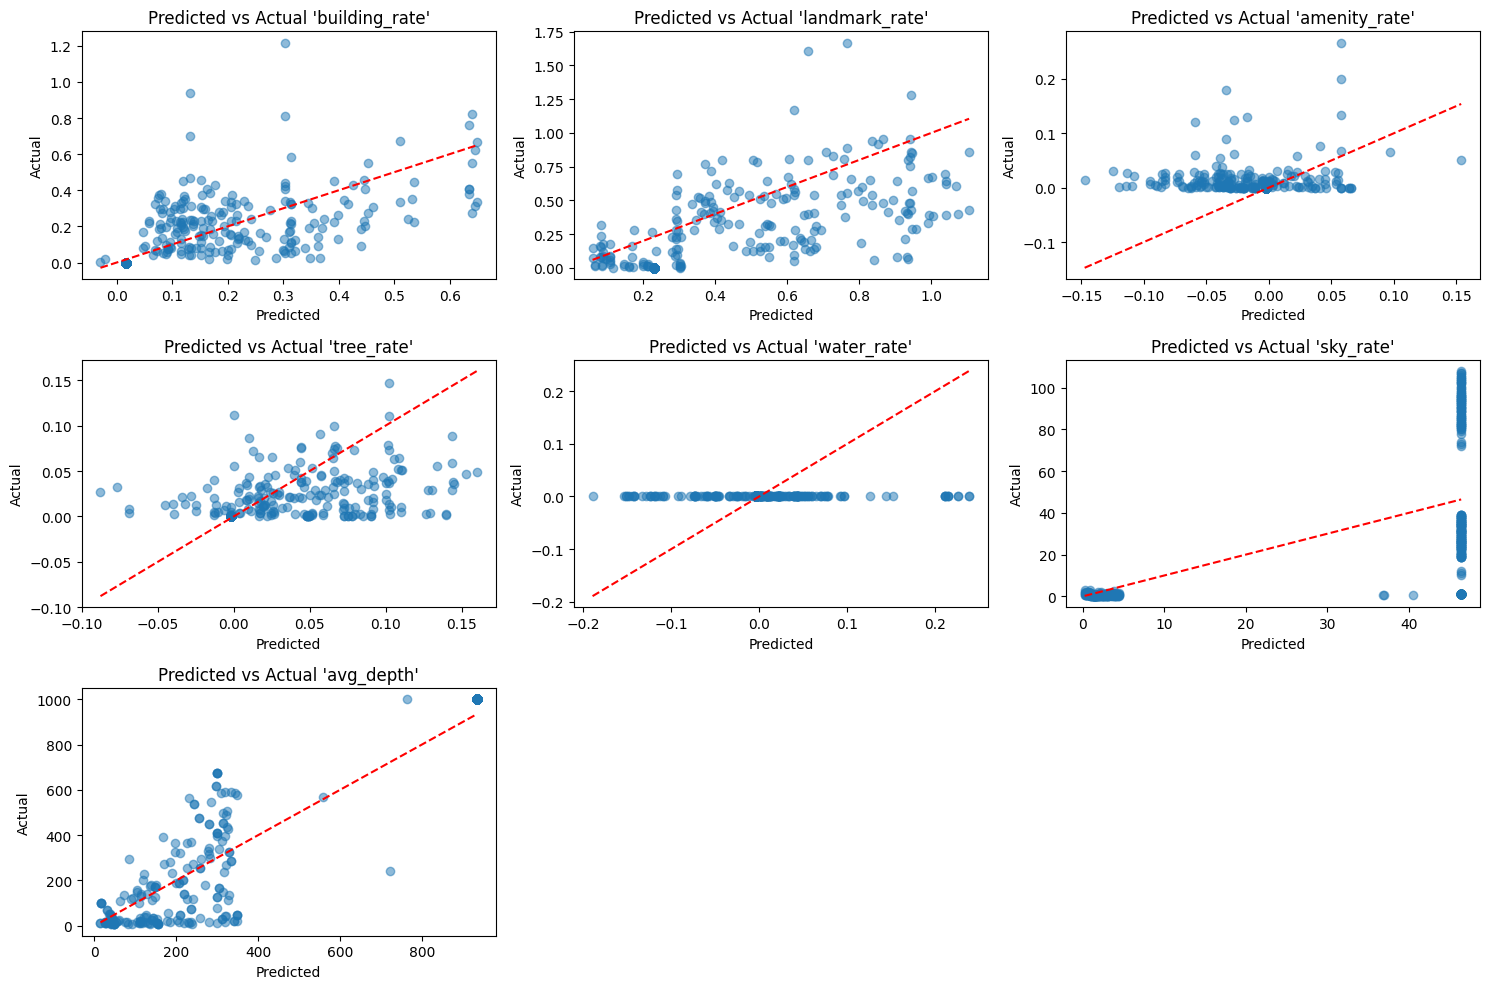

In [169]:
Y_val_pred = best_trial_mlp.user_attrs["Y_val_pred"]

plt.figure(figsize=(15, 10))

# Create a subplot for each output dimension
for i, column_name in enumerate(column_names):
    plt.subplot(3, 3, i + 1)
    plt.scatter(Y_val_pred[:, i], Y_multiout_val.iloc[:, i], alpha=0.5)
    plt.plot([Y_val_pred[:, i].min(), Y_val_pred[:, i].max()], [Y_val_pred[:, i].min(), Y_val_pred[:, i].max()], "r--")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Predicted vs Actual '{column_name}'")

plt.tight_layout()
plt.show()

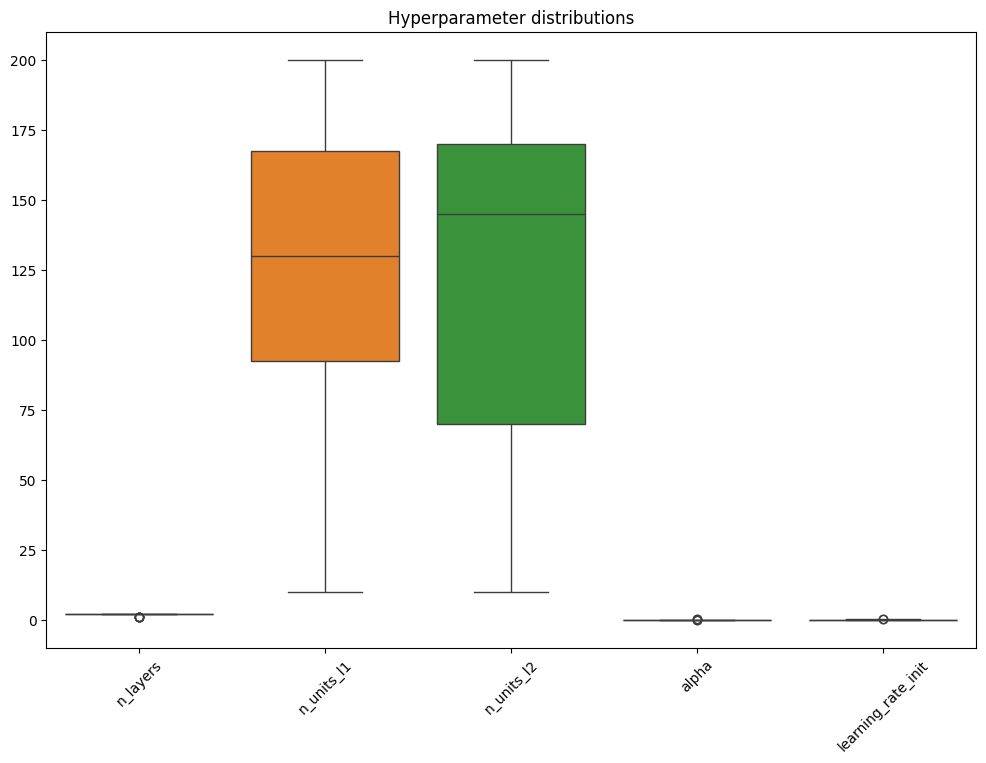

n_layers: Mean=1.8000, CI=(1.016, 2.584)
n_units_l1: Mean=123.6667, CI=(21.635744120824924, 225.69758921250843)
n_units_l2: Mean=122.9167, CI=(10.53965364551739, 235.29367968781594)
alpha: Mean=0.0087, CI=(-0.02654770785244846, 0.0439055735165423)
learning_rate_init: Mean=0.0190, CI=(-0.023136073805396878, 0.061127421930416384)


In [170]:
plot_hyperparameter_distributions(study_mlp)

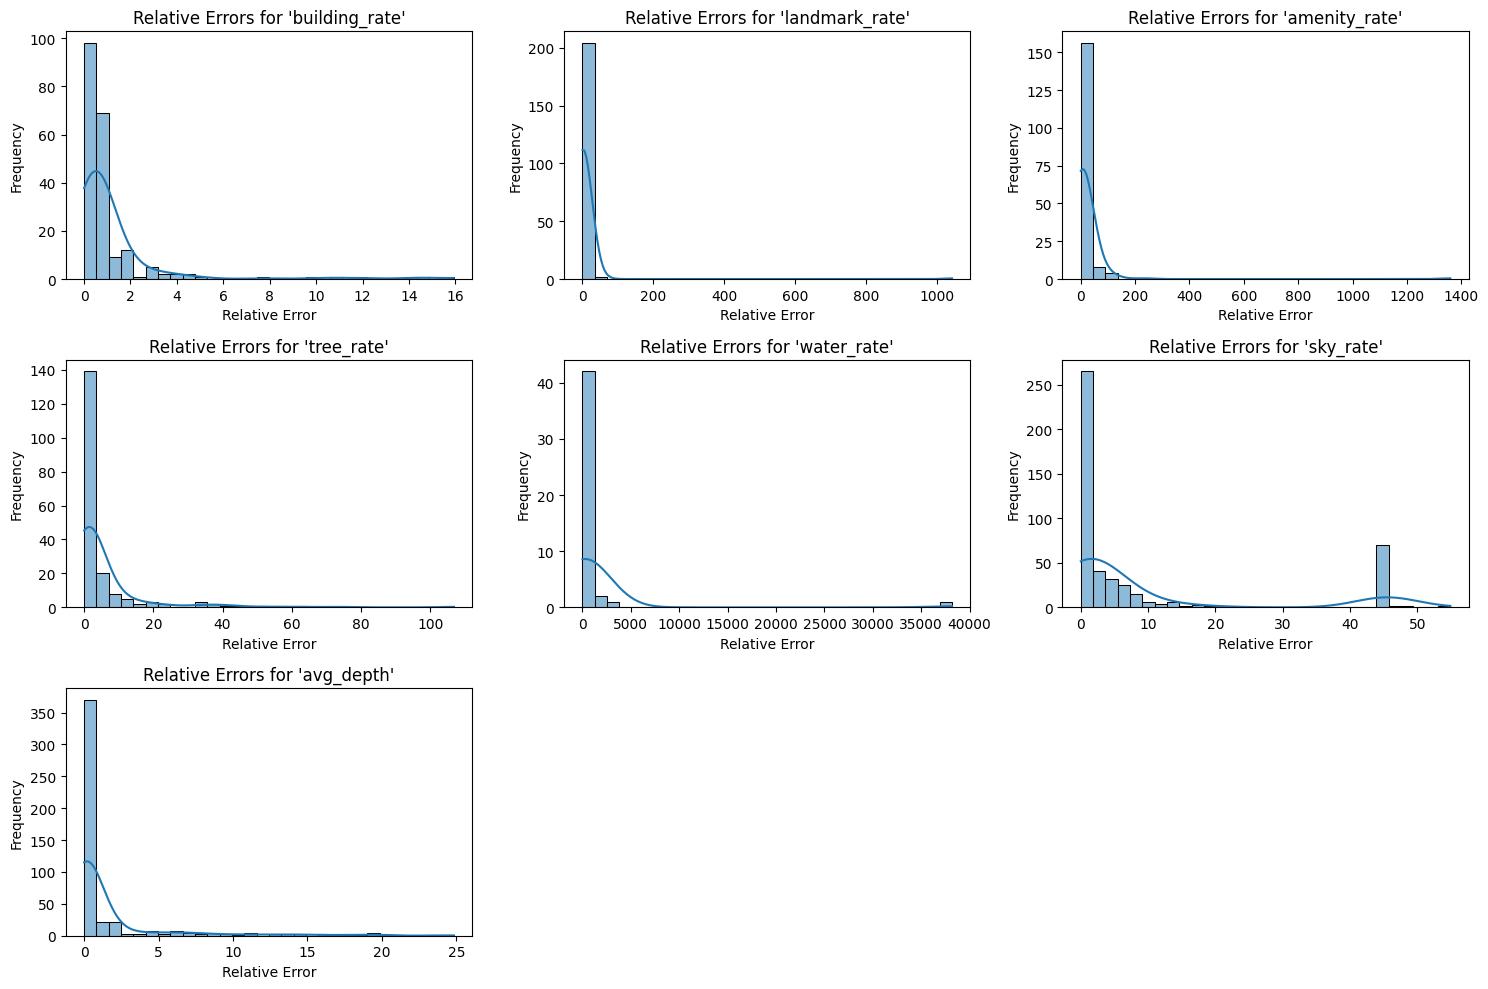

Mean Relative Error for 'building_rate': 1.1543
Mean Relative Error for 'landmark_rate': 7.6358
Mean Relative Error for 'amenity_rate': 21.6450
Mean Relative Error for 'tree_rate': 5.6768
Mean Relative Error for 'water_rate': 1134.4316
Mean Relative Error for 'sky_rate': 9.1915
Mean Relative Error for 'avg_depth': 1.4886


In [171]:
Y_val_pred = best_trial_mlp.user_attrs["Y_val_pred"]

relative_errors = compute_relative_errors(Y_multiout_val, Y_val_pred)

plt.figure(figsize=(15, 10))

# Create a subplot for each output dimension
for i, column_name in enumerate(column_names):
    plt.subplot(3, 3, i + 1)
    sns.histplot(relative_errors.values[:, i], bins=30, kde=True)
    plt.xlabel("Relative Error")
    plt.ylabel("Frequency")
    plt.title(f"Relative Errors for '{column_name}'")

plt.tight_layout()
plt.show()

mean_relative_errors = np.nanmean(relative_errors, axis=0)
for i, mean_error in enumerate(mean_relative_errors):
    print(f"Mean Relative Error for '{column_names[i]}': {mean_error:.4f}")

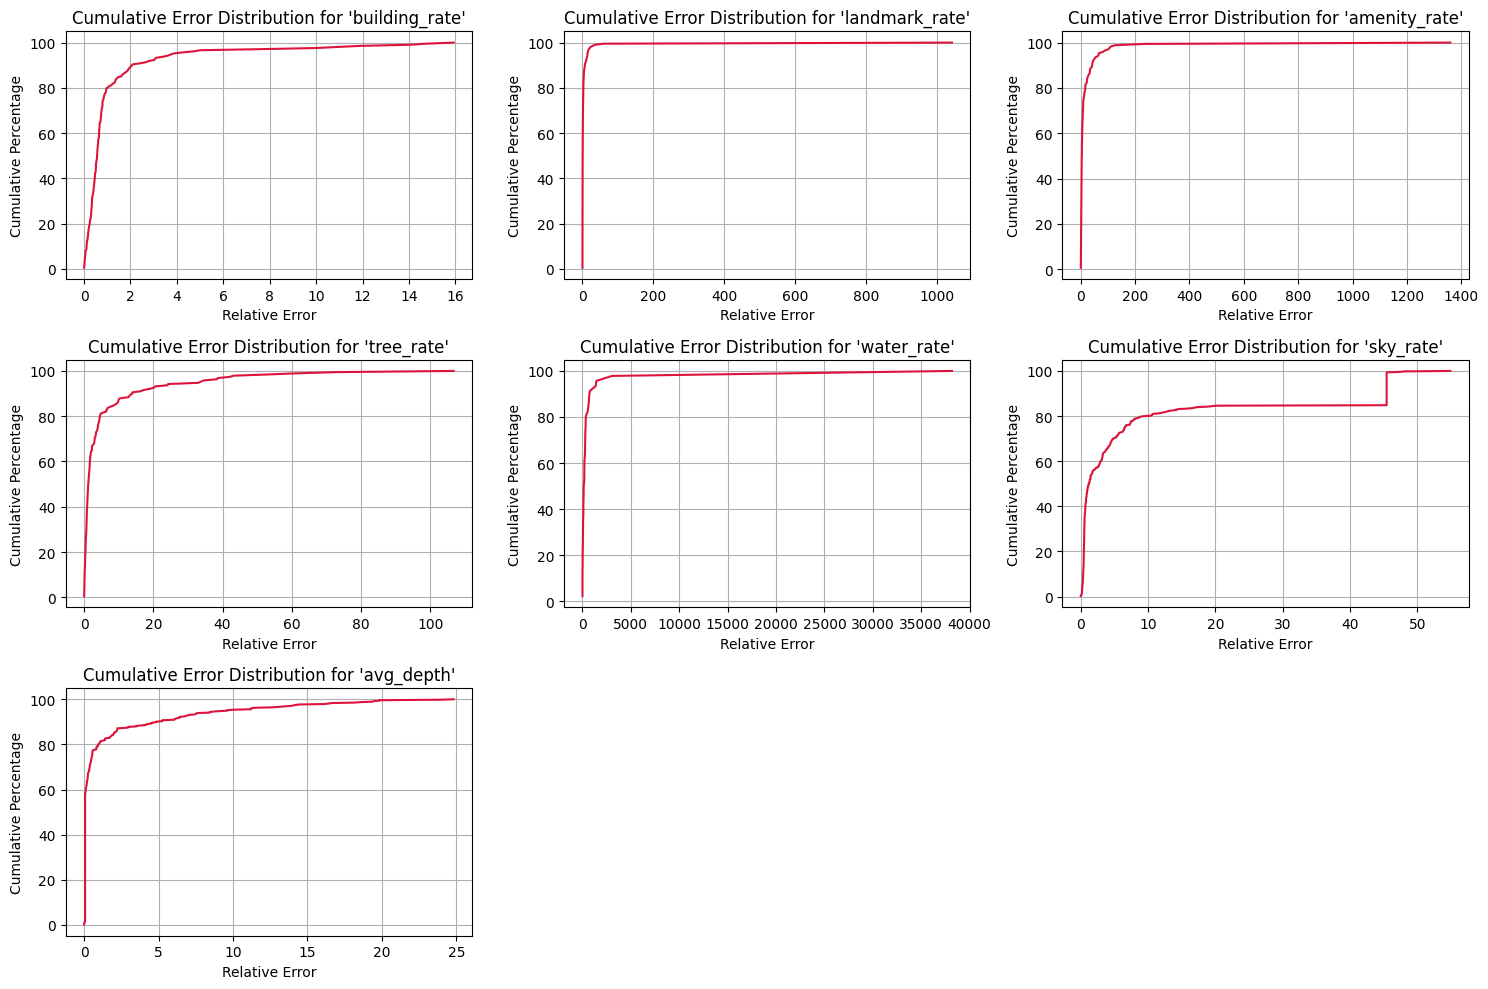

In [172]:
Y_val_pred = best_trial_mlp.user_attrs["Y_val_pred"]

relative_errors = compute_relative_errors(Y_multiout_val, Y_val_pred)

plt.figure(figsize=(15, 10))

# Create a subplot for each output dimension
for i, column_name in enumerate(column_names):
    plt.subplot(3, 3, i + 1)
    
    # Extract and sort the relative errors for the current column
    errors = relative_errors.values[:, i]
    errors_sorted = np.sort(errors[~np.isnan(errors)])  # Remove NaNs and sort
    
    # Calculate the cumulative percentage
    cumulative_percent = np.arange(1, len(errors_sorted) + 1) / len(errors_sorted) * 100
    
    plt.plot(errors_sorted, cumulative_percent, color='crimson')
    plt.xlabel("Relative Error")
    plt.ylabel("Cumulative Percentage")
    plt.title(f"Cumulative Error Distribution for '{column_name}'")
    plt.grid(True)

plt.tight_layout()
plt.show()

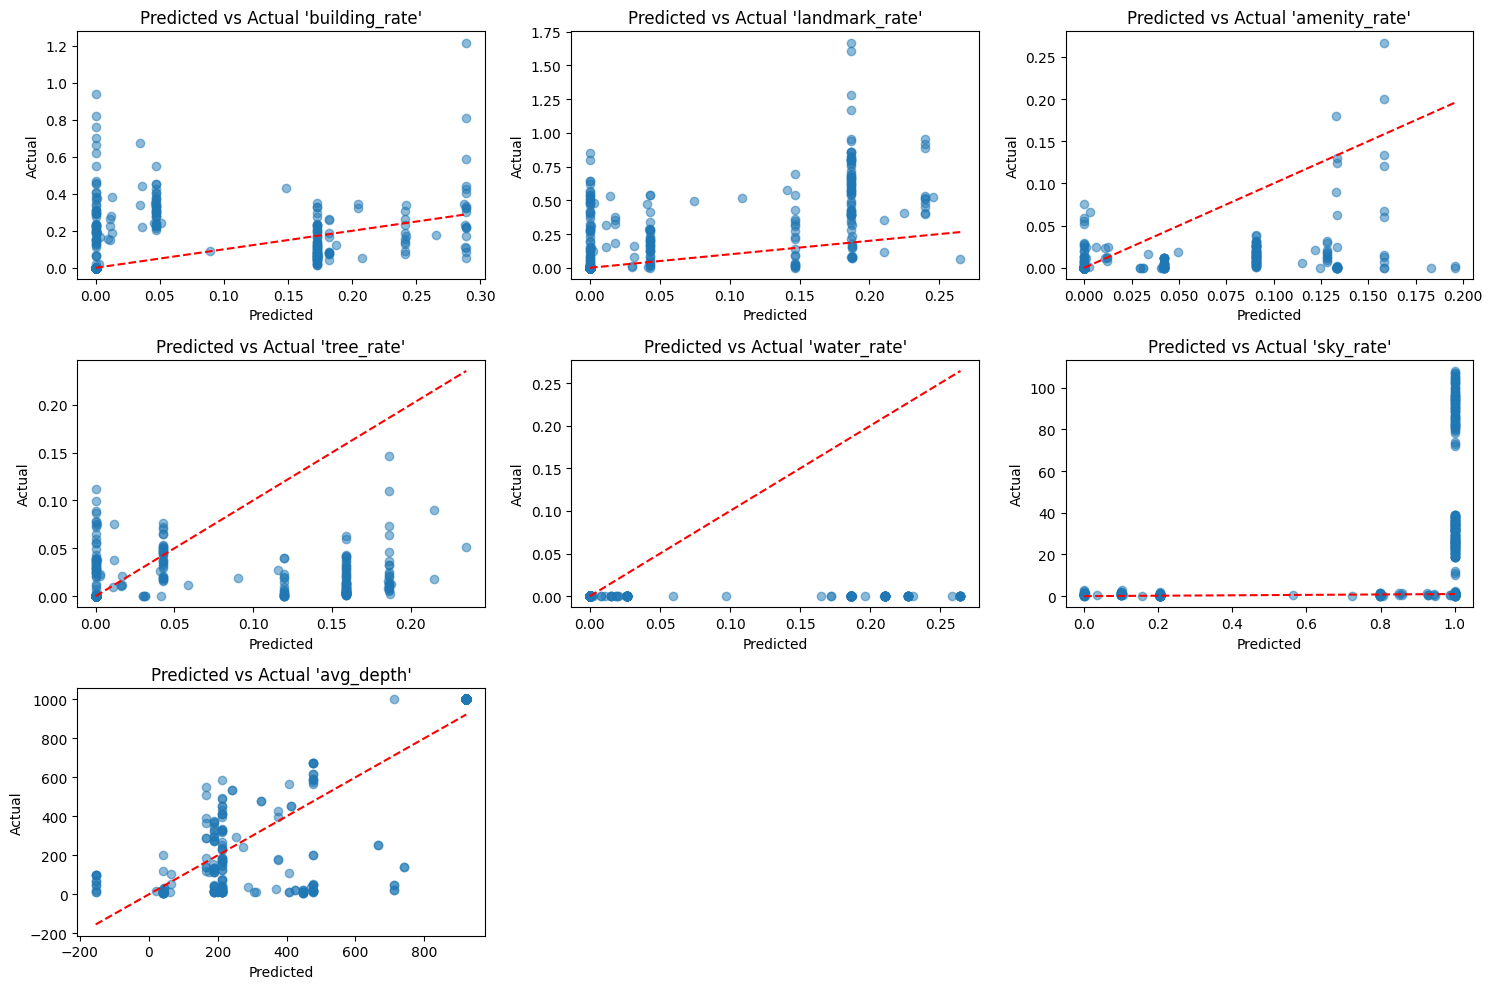

In [173]:
Y_val_color_pred = best_trial_mlp_kl.user_attrs["Y_val_color_pred"]
Y_val_depth_pred = best_trial_mlp_kl.user_attrs["Y_val_depth_pred"]

plot_predicted_vs_actual(Y_val_color, Y_val_color_pred,
                         Y_val_depth, Y_val_depth_pred,
                         column_names)

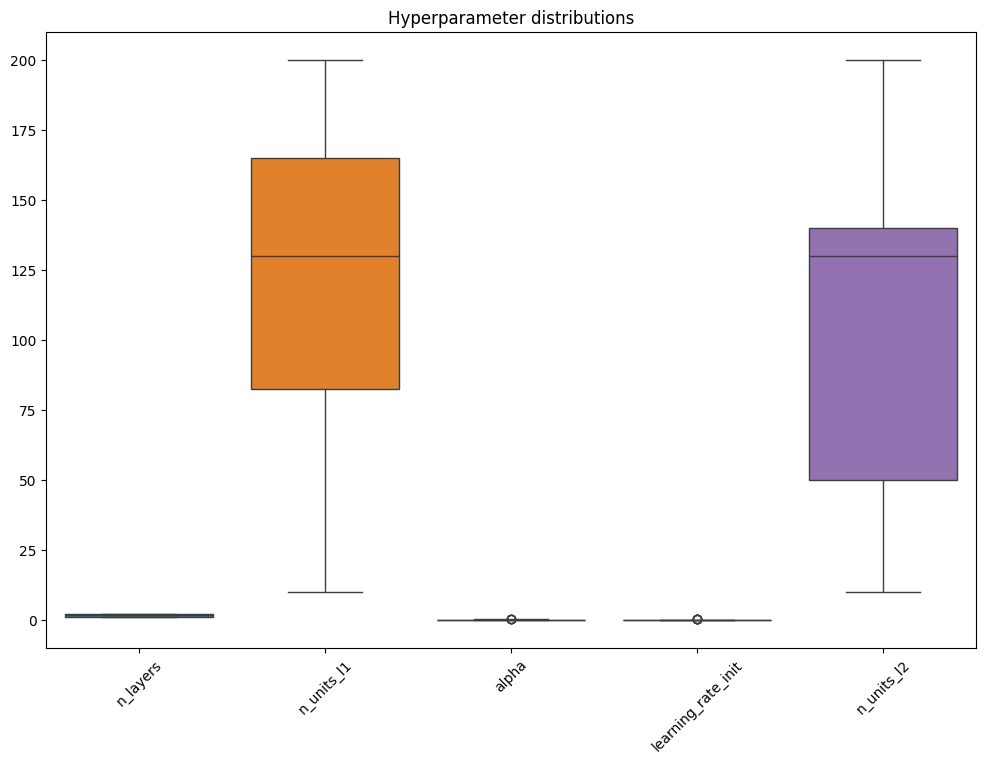

n_layers: Mean=1.5000, CI=(0.52, 2.48)
n_units_l1: Mean=118.3333, CI=(6.300477041578958, 230.3661896250877)
alpha: Mean=0.0205, CI=(-0.03783968995902739, 0.07876122897033933)
learning_rate_init: Mean=0.0161, CI=(-0.03243909563811323, 0.0646895489336817)
n_units_l2: Mean=102.6667, CI=(-13.72205825498925, 219.0553915883226)


In [174]:
plot_hyperparameter_distributions(study_mlp_kl)

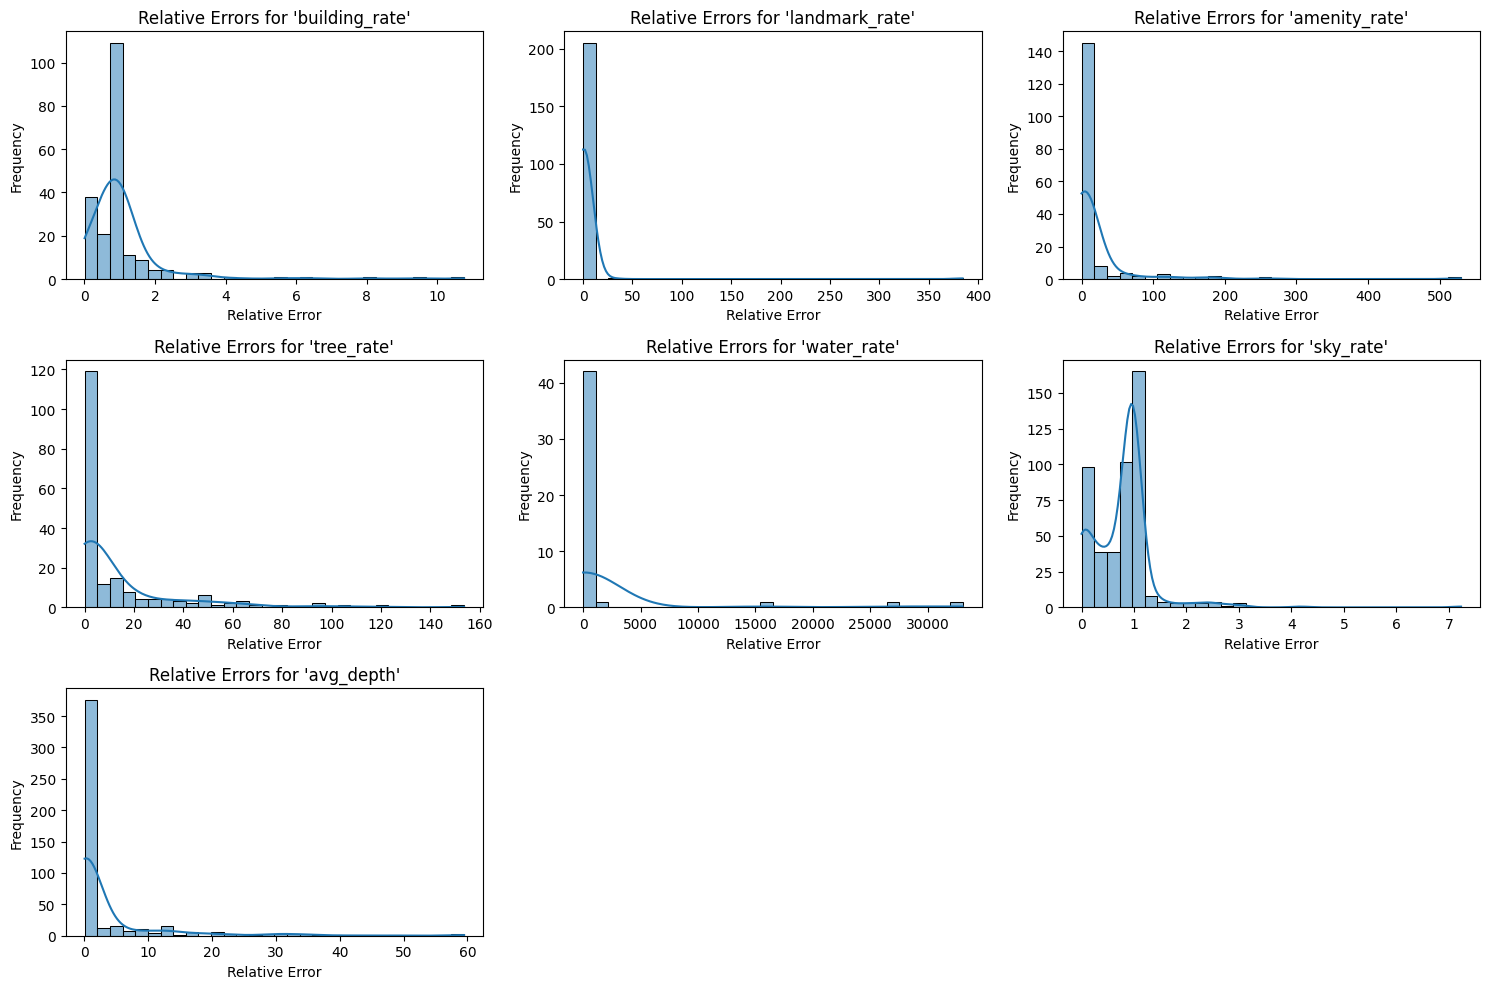

In [175]:
Y_val_color_pred = best_trial_mlp_kl.user_attrs["Y_val_color_pred"]
Y_val_depth_pred = best_trial_mlp_kl.user_attrs["Y_val_depth_pred"]

plot_relative_errors(Y_val_color, Y_val_color_pred,
                     Y_val_depth, Y_val_depth_pred,
                     column_names)

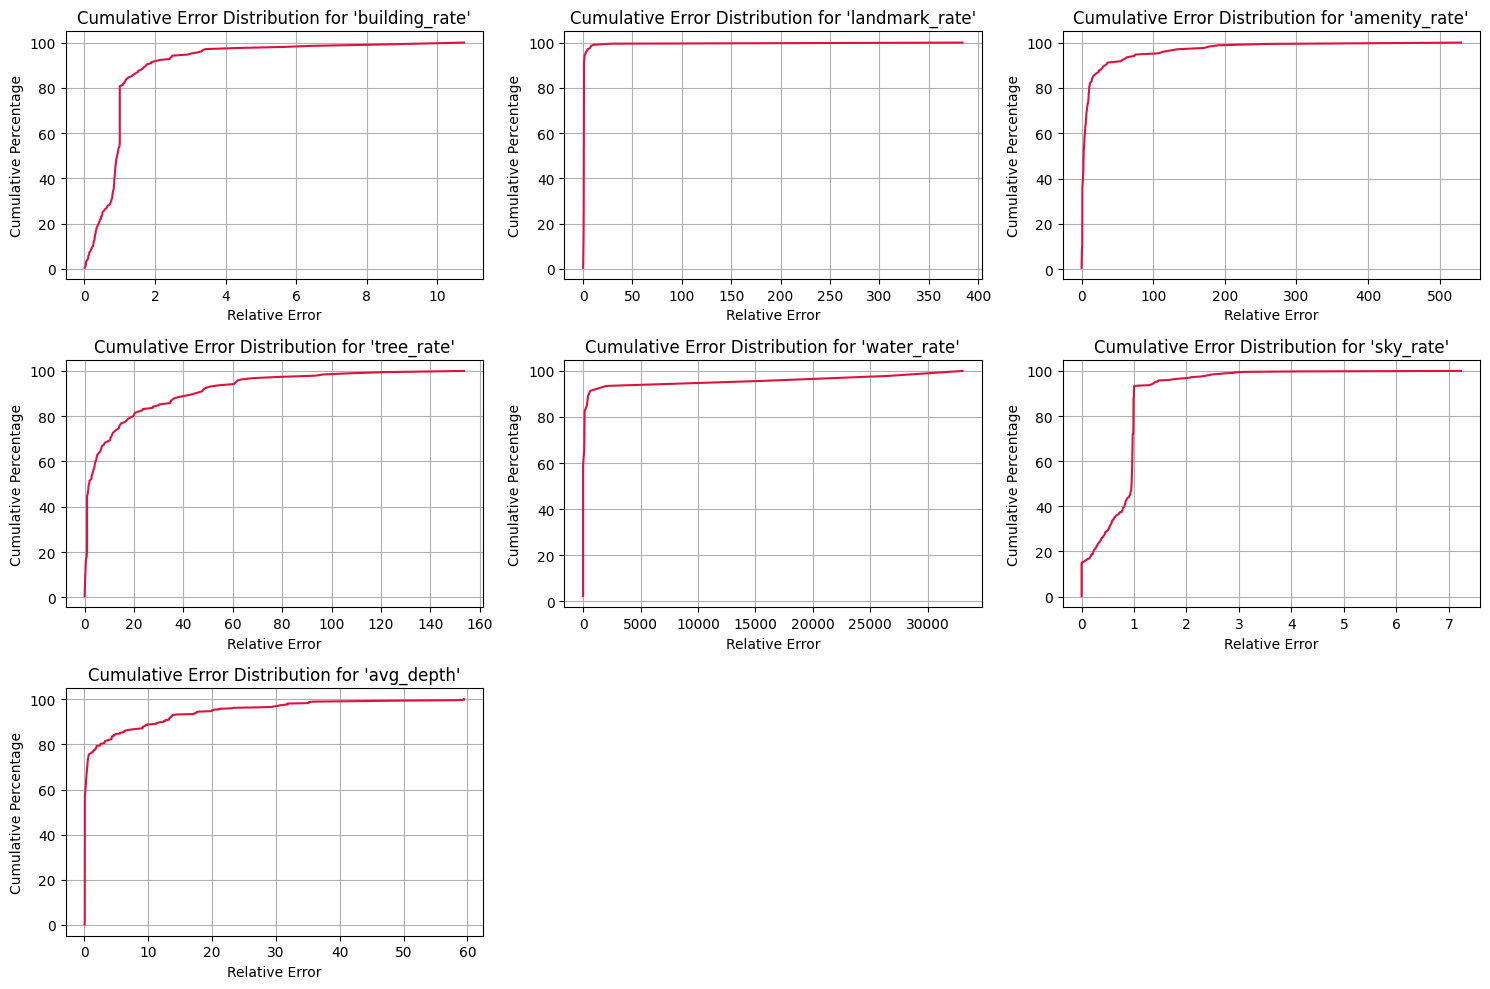

In [176]:
Y_val_color_pred = best_trial_mlp_kl.user_attrs["Y_val_color_pred"]
Y_val_depth_pred = best_trial_mlp_kl.user_attrs["Y_val_depth_pred"]

plot_cumulative_error_distribution(Y_val_color, Y_val_color_pred,
                                   Y_val_depth, Y_val_depth_pred,
                                   column_names)

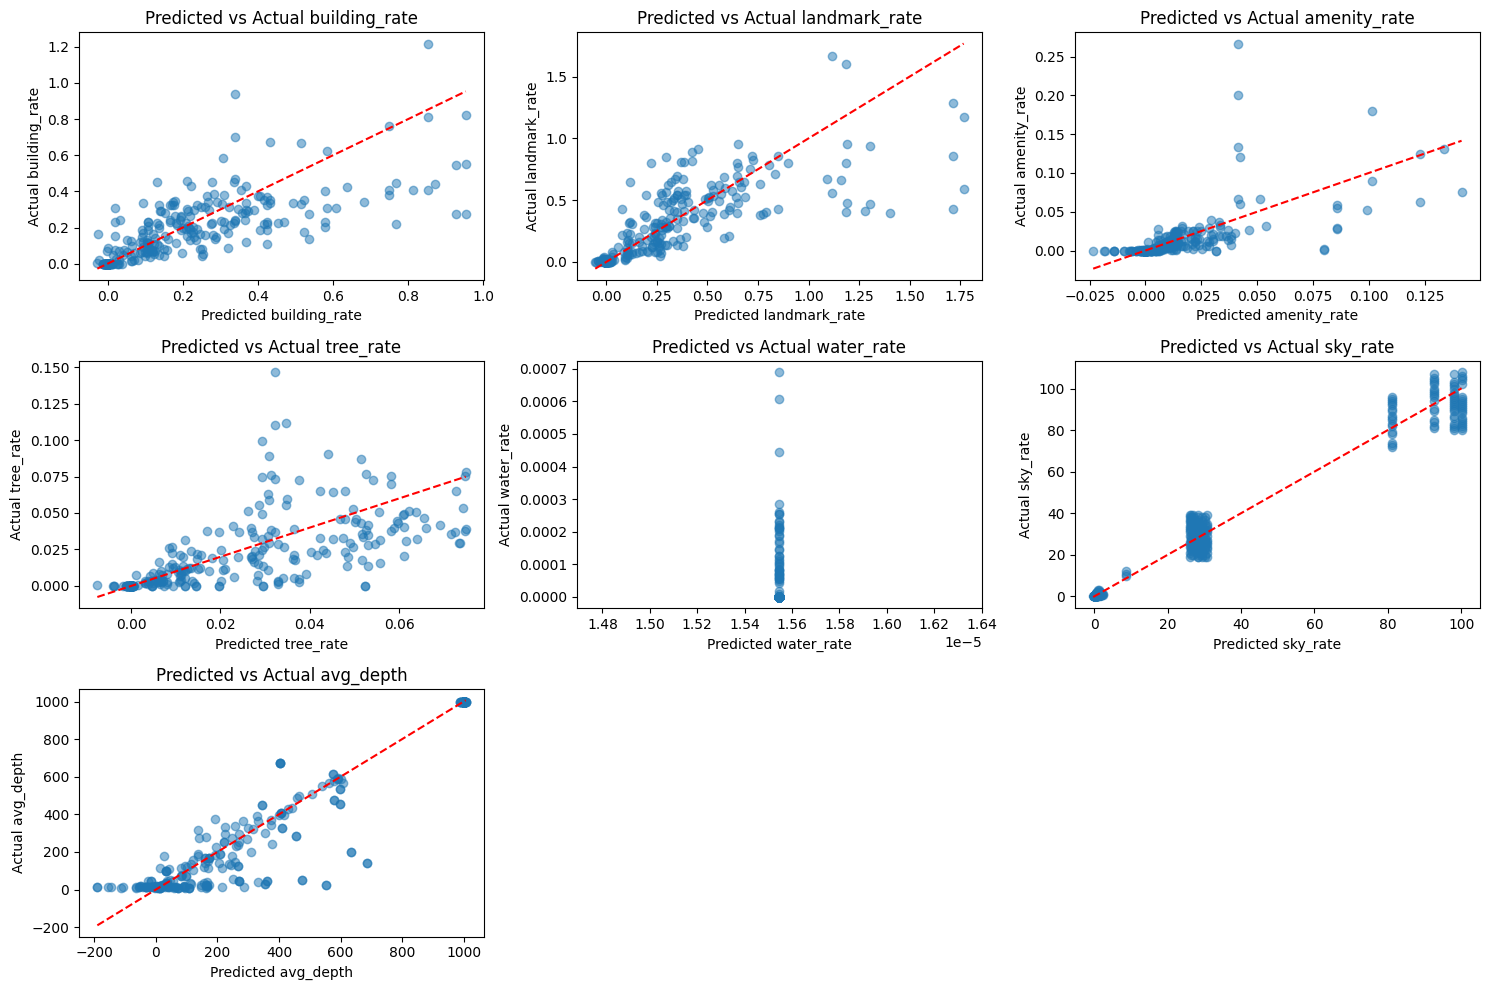

In [177]:
Y_val_pred = best_trial_xgb.user_attrs["Y_val_pred"]

plt.figure(figsize=(15, 10))

# Create a subplot for each output dimension
for i, column in enumerate(column_names):
    plt.subplot(3, 3, i + 1)
    plt.scatter(Y_val_pred[:, i], Y_multiout_val.iloc[:, i], alpha=0.5)
    plt.plot([Y_val_pred[:, i].min(), Y_val_pred[:, i].max()], [Y_val_pred[:, i].min(), Y_val_pred[:, i].max()], "r--")
    plt.xlabel("Predicted " + column)
    plt.ylabel("Actual " + column)
    plt.title(f"Predicted vs Actual {column}")

plt.tight_layout()
plt.show()

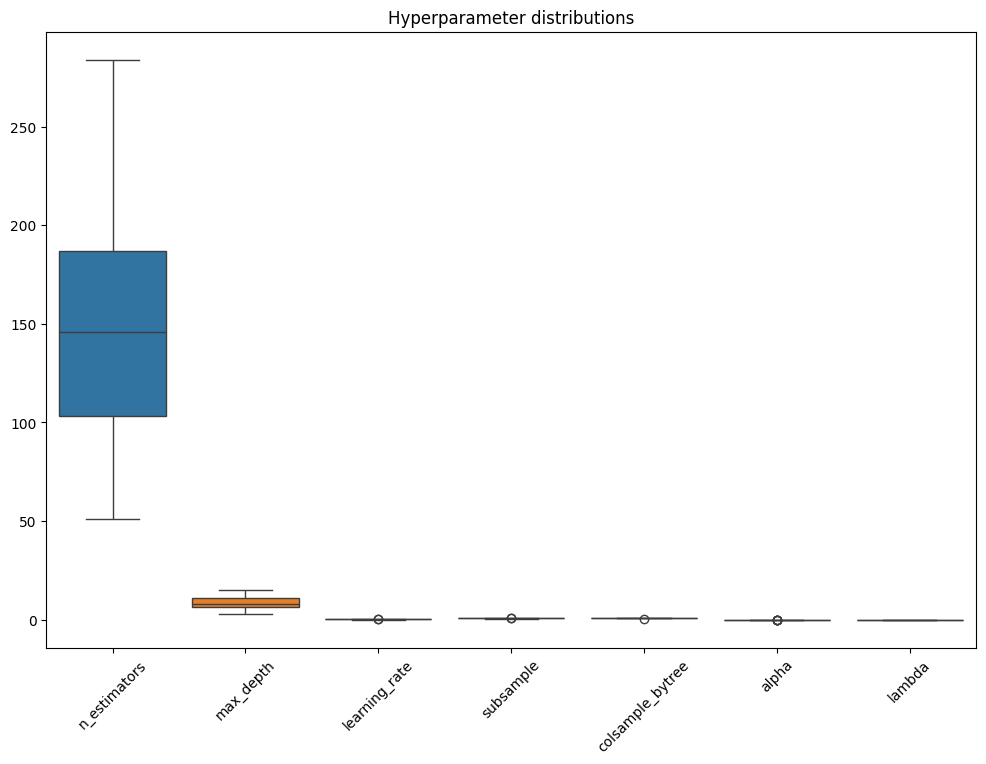

n_estimators: Mean=146.4000, CI=(29.084980853544025, 263.715019146456)
max_depth: Mean=8.4667, CI=(2.212386141387289, 14.720947191946046)
learning_rate: Mean=0.0932, CI=(-0.041747954377009164, 0.2281382381821782)
subsample: Mean=0.7023, CI=(0.46205719357242225, 0.9424443053665454)
colsample_bytree: Mean=0.8505, CI=(0.5853763738571436, 1.1157222101764959)
alpha: Mean=0.0007, CI=(-0.002909068020712313, 0.004407834823987936)
lambda: Mean=0.0031, CI=(-0.0032604516625478804, 0.009374437767249357)


In [178]:
plot_hyperparameter_distributions(study_xgb)

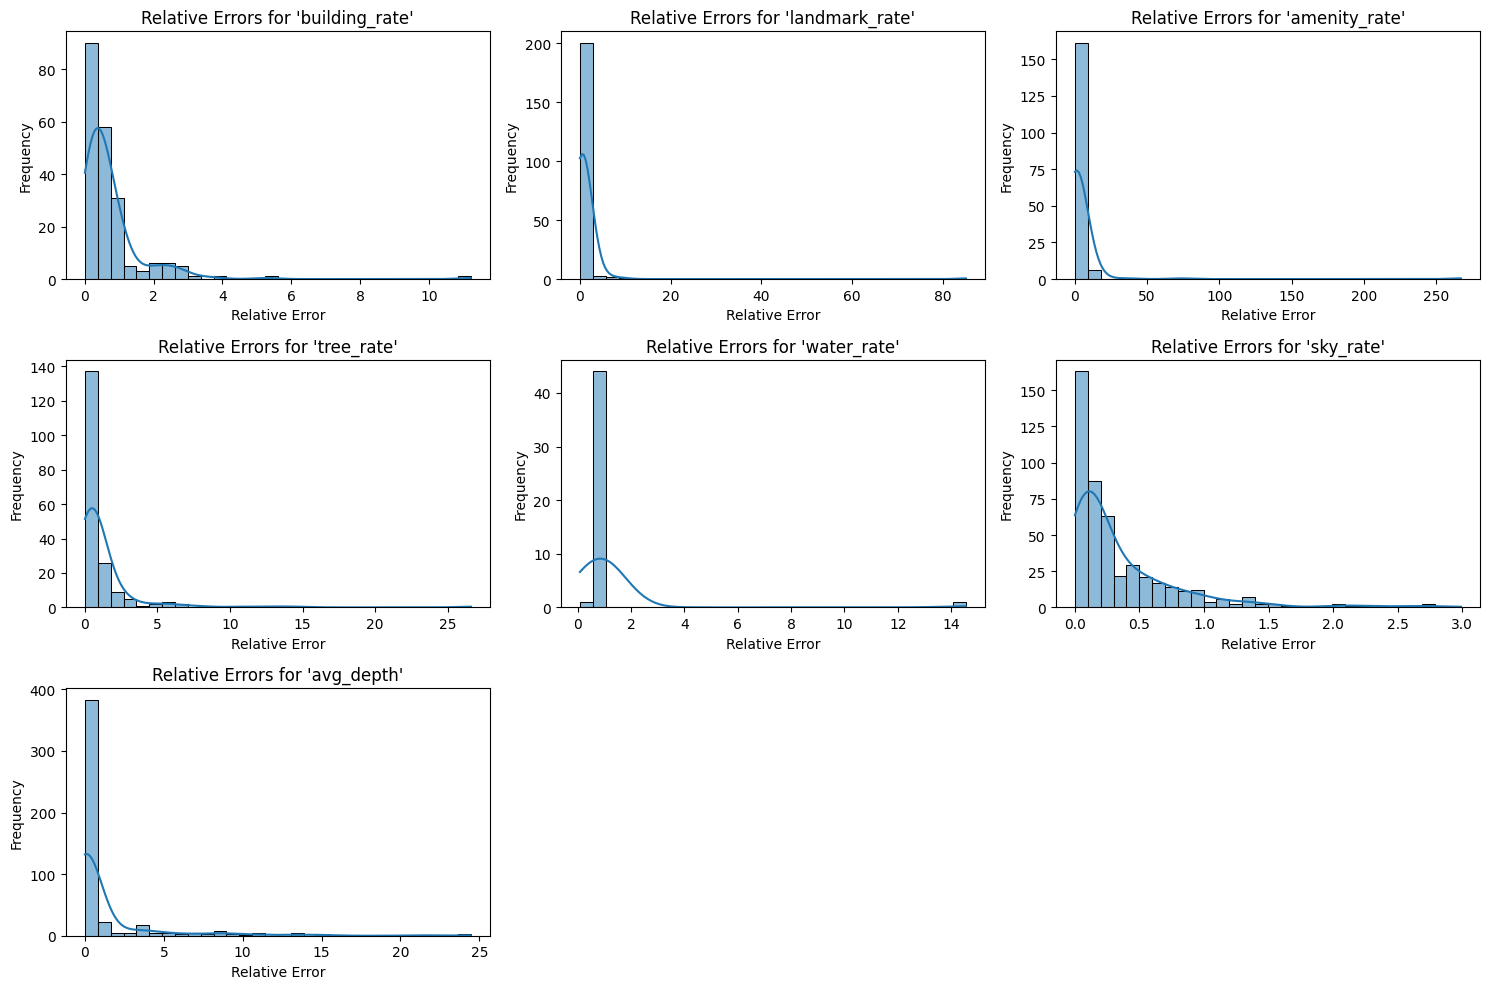

Mean Relative Error for 'building_rate': 0.7357
Mean Relative Error for 'landmark_rate': 1.1681
Mean Relative Error for 'amenity_rate': 3.8104
Mean Relative Error for 'tree_rate': 1.2242
Mean Relative Error for 'water_rate': 1.1401
Mean Relative Error for 'sky_rate': 0.3509
Mean Relative Error for 'avg_depth': 1.1962


In [179]:
Y_val_pred = best_trial_xgb.user_attrs["Y_val_pred"]

relative_errors = compute_relative_errors(Y_multiout_val, Y_val_pred)

plt.figure(figsize=(15, 10))

# Create a subplot for each output dimension
for i, column_name in enumerate(column_names):
    plt.subplot(3, 3, i + 1)
    sns.histplot(relative_errors.values[:, i], bins=30, kde=True)
    plt.xlabel("Relative Error")
    plt.ylabel("Frequency")
    plt.title(f"Relative Errors for '{column_name}'")

plt.tight_layout()
plt.show()

mean_relative_errors = np.nanmean(relative_errors, axis=0)
for i, mean_error in enumerate(mean_relative_errors):
    print(f"Mean Relative Error for '{column_names[i]}': {mean_error:.4f}")

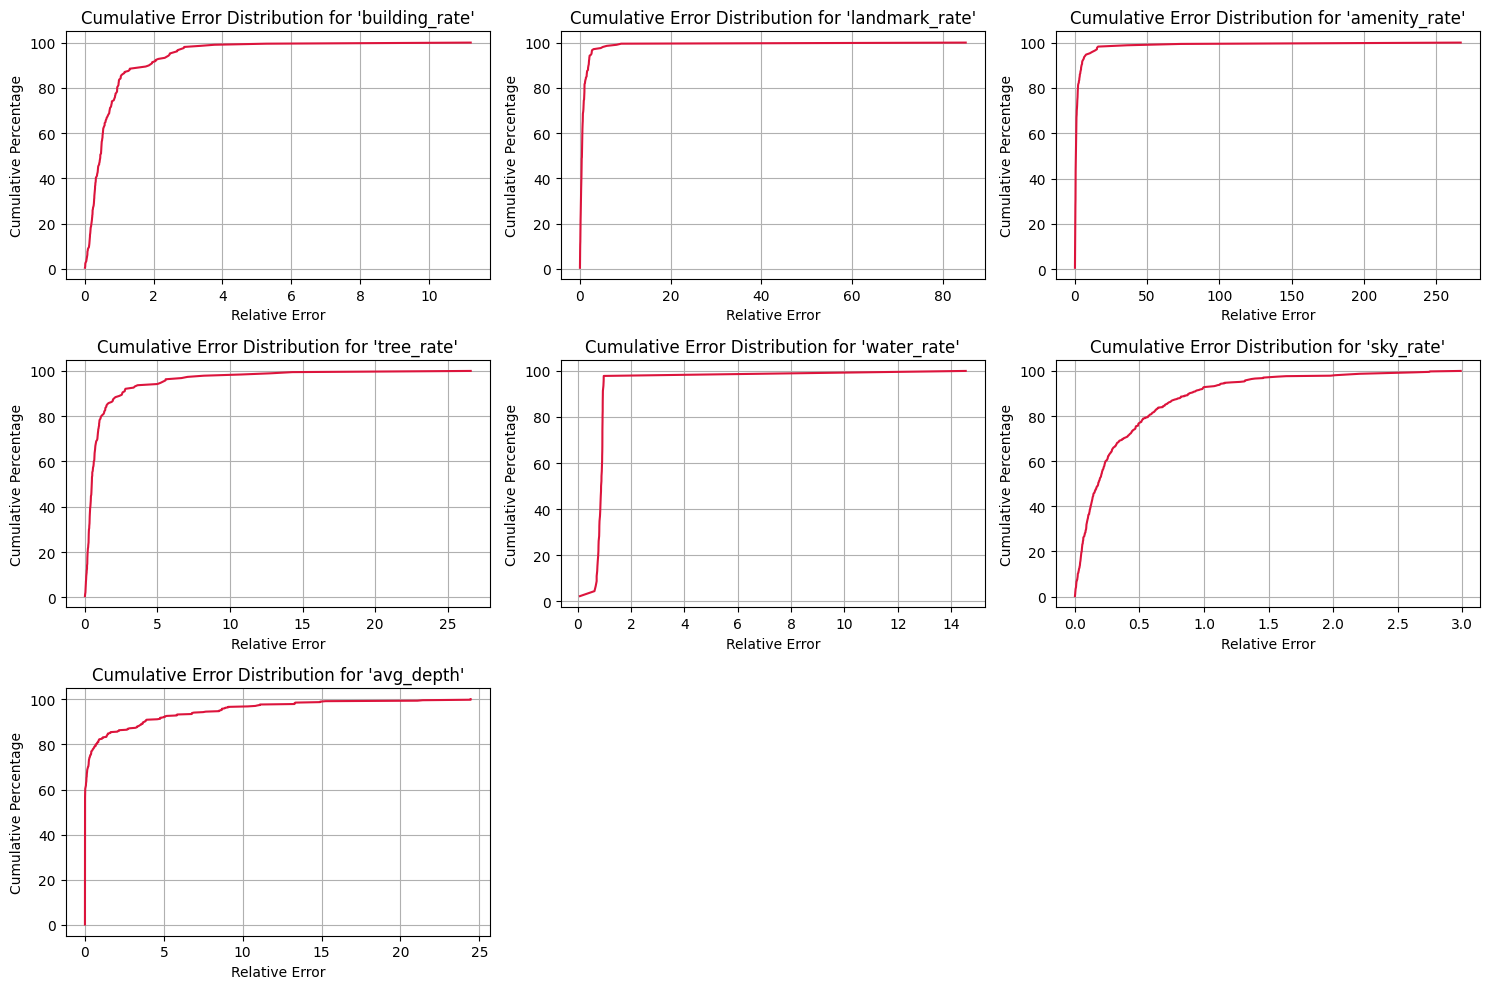

In [180]:
Y_val_pred = best_trial_xgb.user_attrs["Y_val_pred"]

relative_errors = compute_relative_errors(Y_multiout_val, Y_val_pred)

plt.figure(figsize=(15, 10))

# Create a subplot for each output dimension
for i, column_name in enumerate(column_names):
    plt.subplot(3, 3, i + 1)
    
    # Extract and sort the relative errors for the current column
    errors = relative_errors.values[:, i]
    errors_sorted = np.sort(errors[~np.isnan(errors)])  # Remove NaNs and sort
    
    # Calculate the cumulative percentage
    cumulative_percent = np.arange(1, len(errors_sorted) + 1) / len(errors_sorted) * 100
    
    plt.plot(errors_sorted, cumulative_percent, color='crimson')
    plt.xlabel("Relative Error")
    plt.ylabel("Cumulative Percentage")
    plt.title(f"Cumulative Error Distribution for '{column_name}'")
    plt.grid(True)

plt.tight_layout()
plt.show()

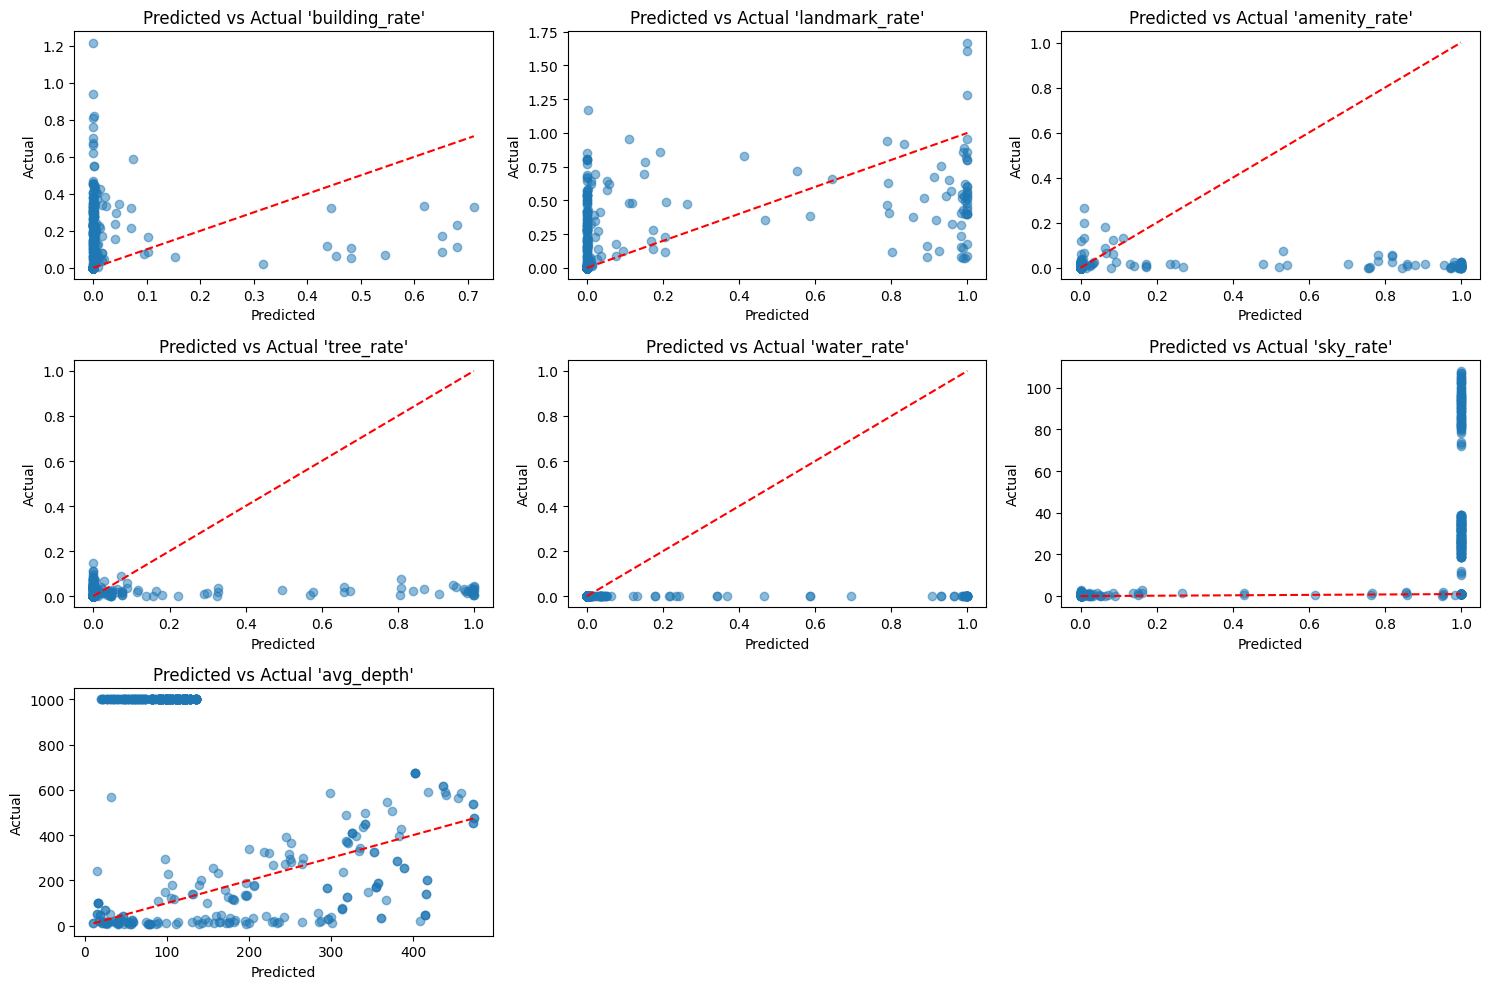

In [181]:
Y_val_color_pred = best_trial_xgb_kl.user_attrs["Y_val_color_pred"]
Y_val_depth_pred = best_trial_xgb_kl.user_attrs["Y_val_depth_pred"]

plot_predicted_vs_actual(Y_val_color, Y_val_color_pred,
                         Y_val_depth, Y_val_depth_pred,
                         column_names)

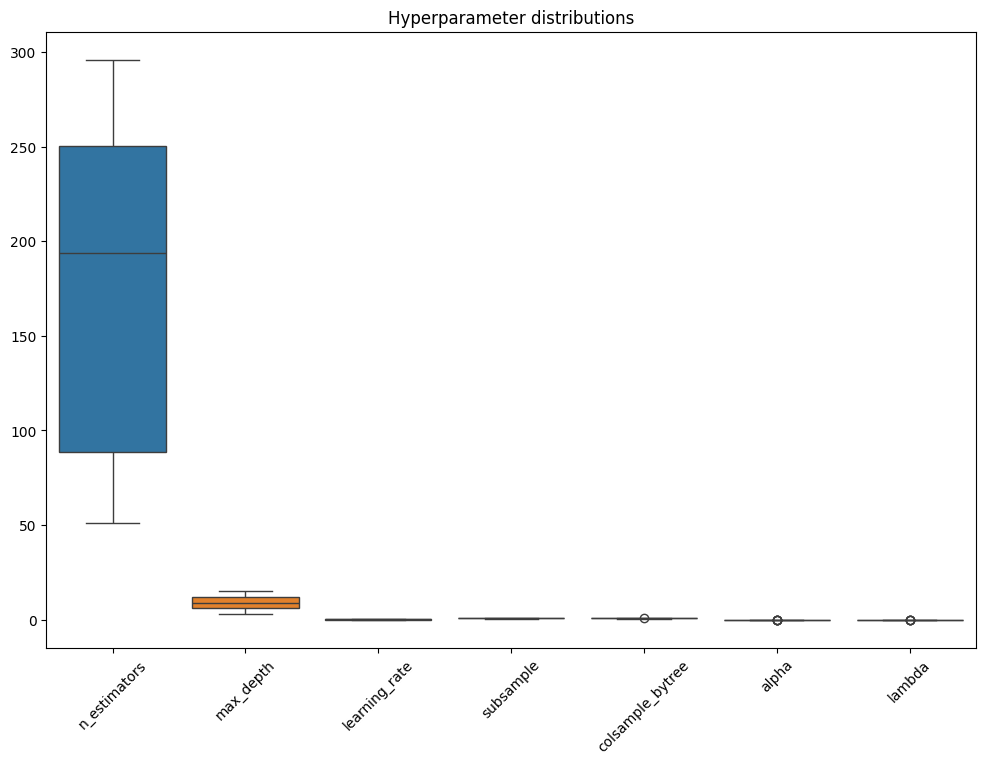

n_estimators: Mean=180.7000, CI=(17.847587748906818, 343.5524122510932)
max_depth: Mean=8.9333, CI=(2.1449516246915588, 15.72171504197511)
learning_rate: Mean=0.0925, CI=(-0.06654677579159579, 0.25146013268698625)
subsample: Mean=0.7284, CI=(0.4482996999712454, 1.0084107153330495)
colsample_bytree: Mean=0.7078, CI=(0.4512726958789957, 0.9642463943093491)
alpha: Mean=0.0007, CI=(-0.0018554297400214608, 0.003221285726699066)
lambda: Mean=0.0017, CI=(-0.0032981361828092197, 0.006677831853437651)


In [182]:
plot_hyperparameter_distributions(study_xgb_kl)

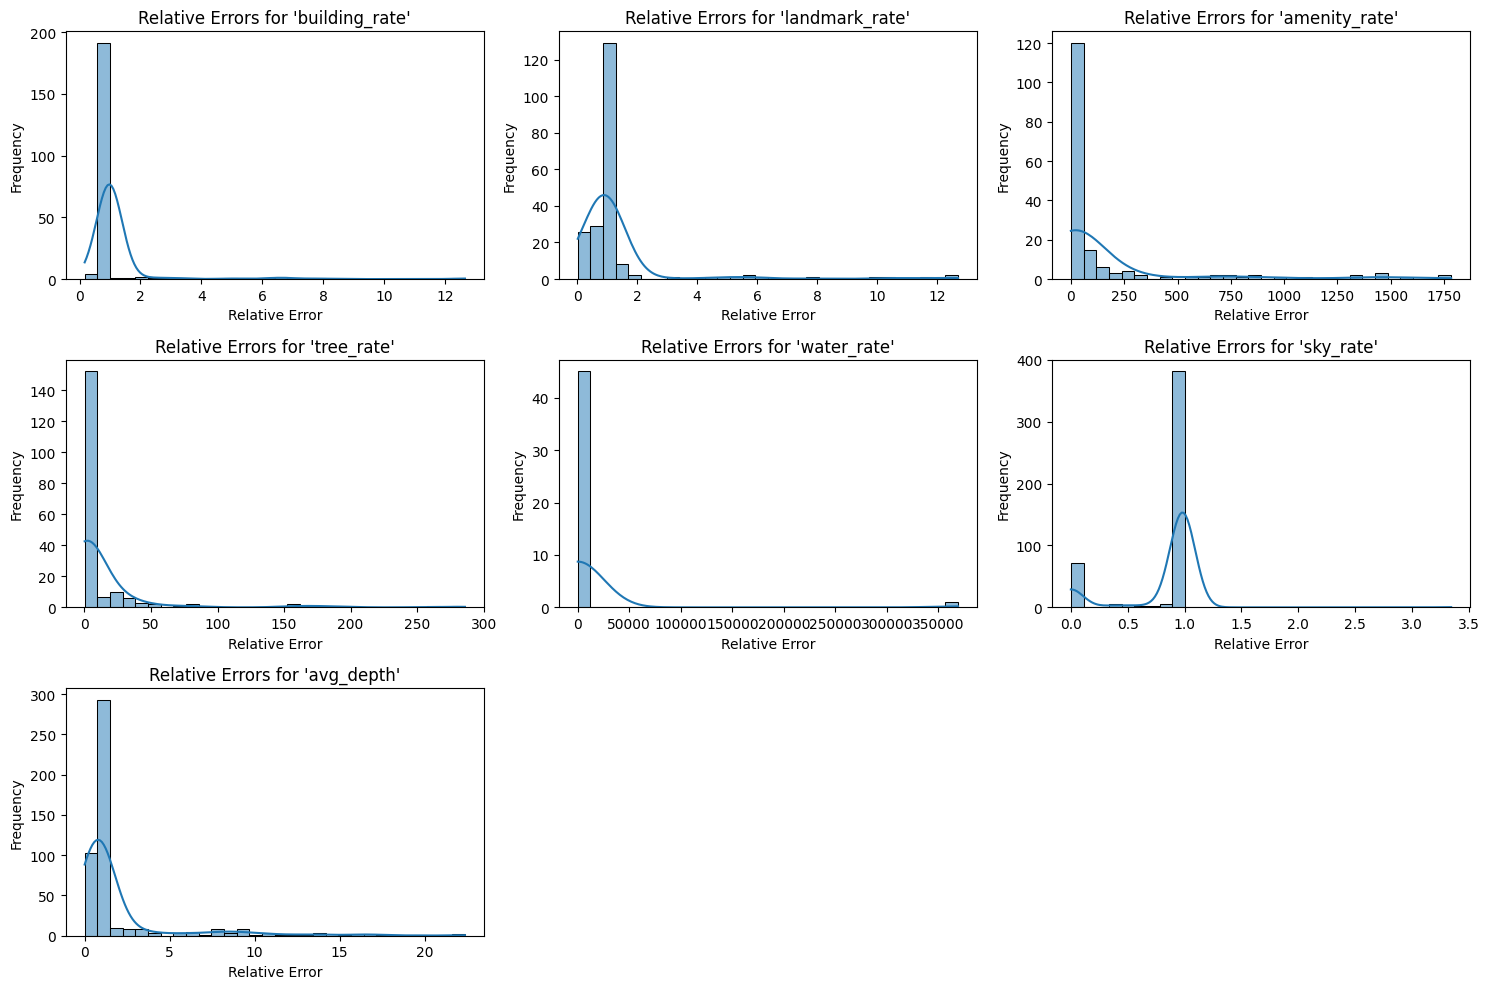

In [183]:
Y_val_color_pred = best_trial_xgb_kl.user_attrs["Y_val_color_pred"]
Y_val_depth_pred = best_trial_xgb_kl.user_attrs["Y_val_depth_pred"]

plot_relative_errors(Y_val_color, Y_val_color_pred,
                     Y_val_depth, Y_val_depth_pred,
                     column_names)

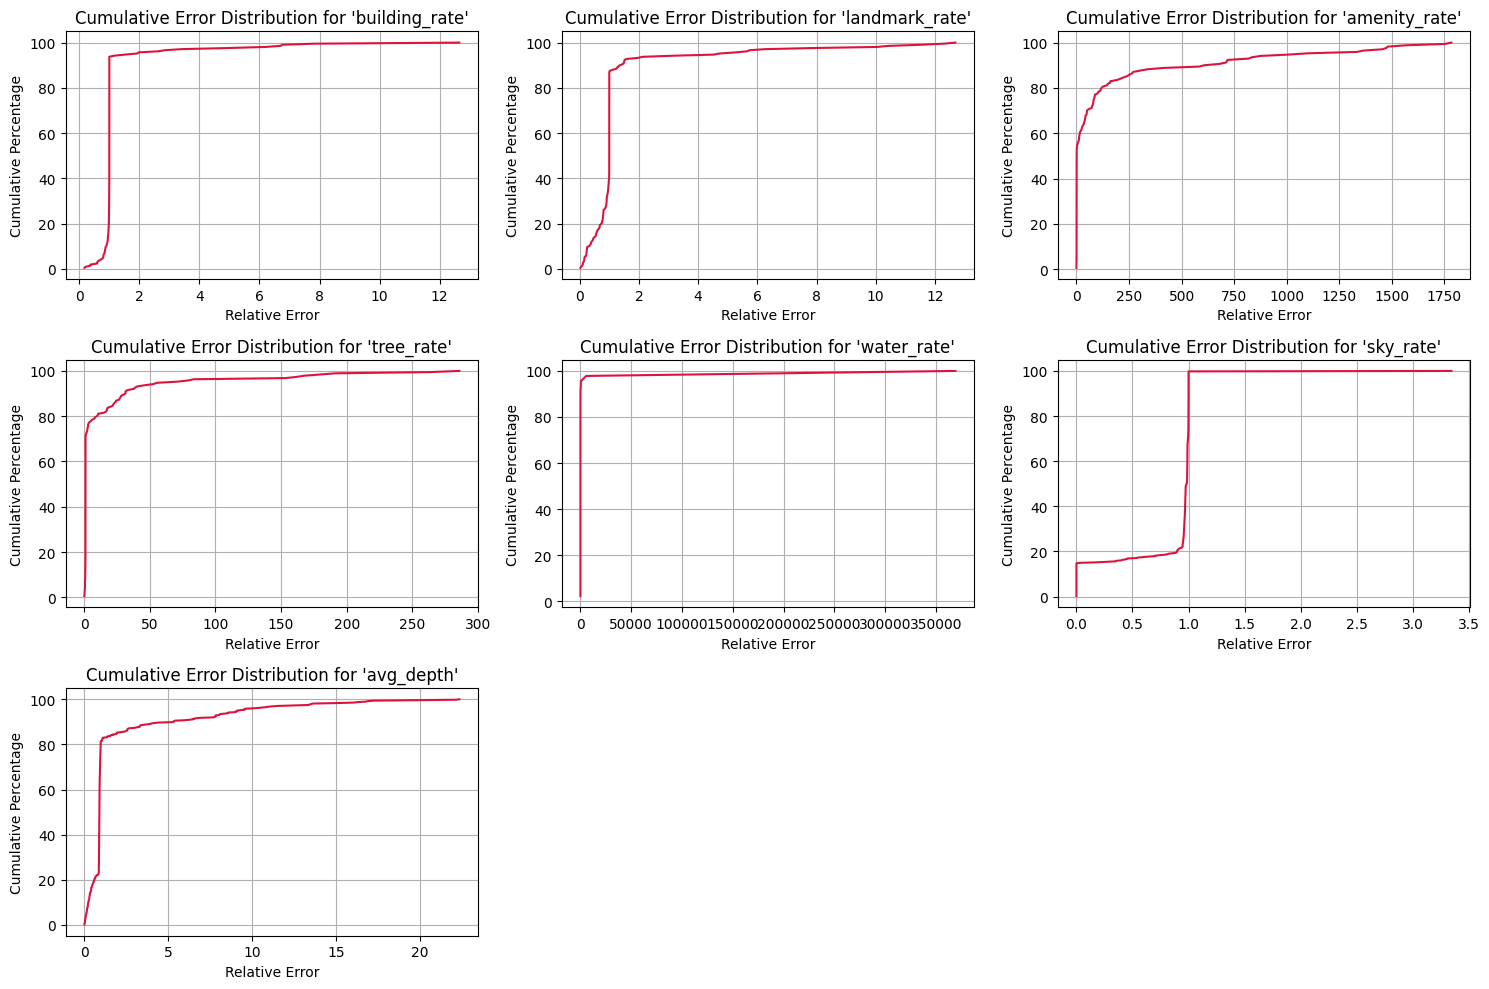

In [184]:
Y_val_color_pred = best_trial_xgb_kl.user_attrs["Y_val_color_pred"]
Y_val_depth_pred = best_trial_xgb_kl.user_attrs["Y_val_depth_pred"]

plot_cumulative_error_distribution(Y_val_color, Y_val_color_pred,
                                   Y_val_depth, Y_val_depth_pred,
                                   column_names)

In [185]:
# Extract results
results = []
for trial in study_mlp.trials:
    results.append({
        "total_neurons": trial.user_attrs.get("total_neurons", None),
        "alpha": trial.params["alpha"],
        "learning_rate_init": trial.params["learning_rate_init"],
        "val_loss": trial.user_attrs.get("val_loss", None),
        "training_time": trial.user_attrs.get("training_time", None),
        "mem_usage": trial.user_attrs.get("mem_usage", None)
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df

,total_neurons,alpha,learning_rate_init,val_loss,training_time,mem_usage
0,100,0.000068,0.008851,9.113269e+04,3.852012,94.809570
1,220,0.000116,0.042265,6.389547e+08,0.458121,244.920898
2,190,0.000179,0.002784,7.949360e+10,0.216730,59.766602
3,180,0.000193,0.032667,6.141201e+05,0.091003,55.997070
4,270,0.000364,0.000130,4.417036e+11,0.270531,443.721680
5,140,0.046782,0.000640,5.951621e+05,0.050996,44.984375
6,170,0.007696,0.000573,5.916688e+05,0.052967,52.750000
7,200,0.086065,0.000139,5.897841e+05,0.354995,62.578125
8,150,0.000242,0.087470,5.916534e+05,0.083005,48.206055
9,150,0.014386,0.000866,3.959328e+05,5.914844,181.587891


##### Best MLP Model Performance

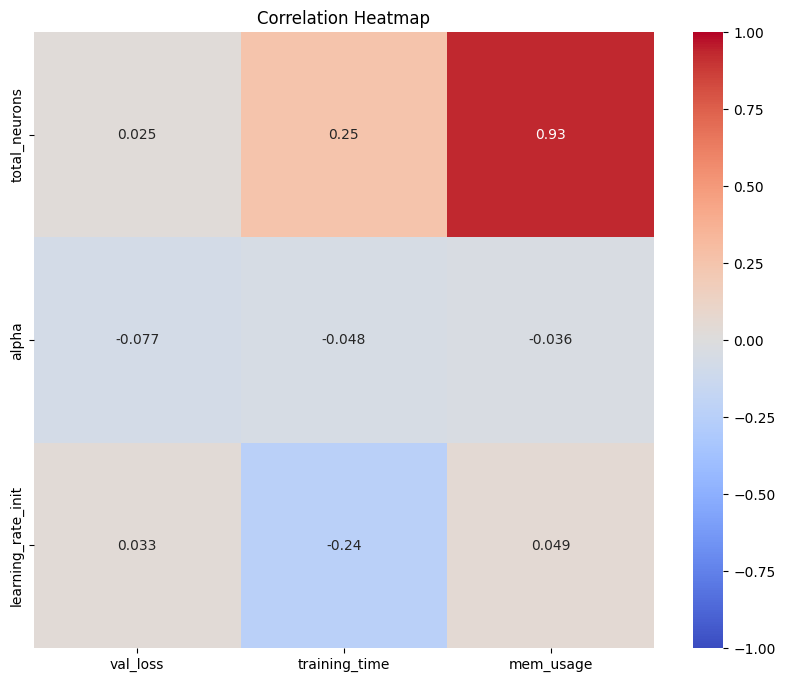

In [189]:
# Compute the correlation matrix
corr_matrix = results_df.corr()

# Select correlations of interest with val_loss, training_time, and mem_usage
corr_of_interest = corr_matrix.loc[["total_neurons", "alpha", "learning_rate_init"], ["val_loss", "training_time", "mem_usage"]]

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_of_interest, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

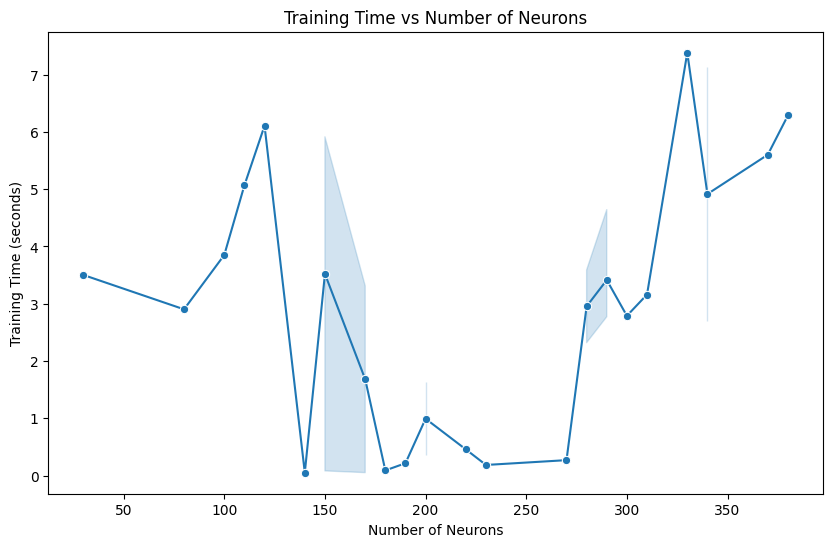

In [187]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="total_neurons", y="training_time", data=results_df, marker="o")
plt.xlabel("Number of Neurons")
plt.ylabel("Training Time (seconds)")
plt.title("Training Time vs Number of Neurons")
plt.show()

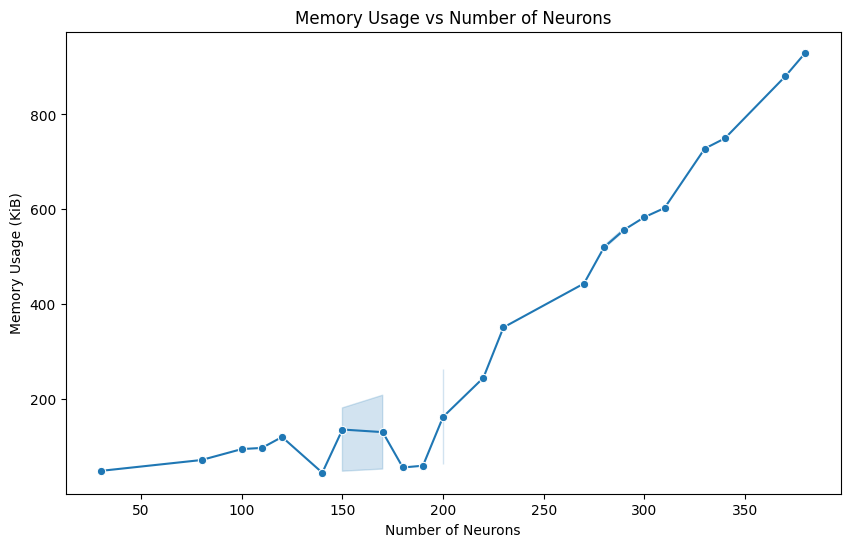

In [188]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="total_neurons", y="mem_usage", data=results_df, marker="o")
plt.xlabel("Number of Neurons")
plt.ylabel("Memory Usage (KiB)")
plt.title("Memory Usage vs Number of Neurons")
plt.show()